# Pipeline Research Centroids

1. Description of datasets (name, # of classes, # features)
2. Feature Importance (Select 12 features) into excel for comparison
3. Balance and Unbalance Datasets (SMOTE)
4. Feature Importance (Select 12 features) into excel AFTER BALANCED AND UNBALANCED
5. Generate Plots (6 plots with {method} suffix and euclidean distance plots)
6. Best UMAP params and silhouette_score

# Important Variables
* Modify this everytime that you want to do some testing.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import numpy as np
from matplotlib.font_manager import FontProperties
import seaborn as sns
import os
from scipy.spatial.distance import euclidean
from adjustText import adjust_text
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder



#####################################
#      Datasets & Folder stored     #
#####################################
main_folder_results = "../CIBCB_paper_2024/results_04_22_top10_figures"
datasets = [
      #(main_folder_results+"/zoo_dataset_unbalanced_7_classes", '../datasets/zoo_binarized_positives.csv'),
      #(main_folder_results+"/zoo_dataset_balanced_7_classes", '../datasets/zoo_binarized_positives_balanced.csv'),
      (main_folder_results+"/paper_dataset_unbalanced_3_classes", '../datasets/_neurogenetic.csv'),
      (main_folder_results+"/paper_dataset_balanced_3_classes", '../datasets/_neurogenetic_balanced.csv'),
      (main_folder_results+"/new_dataset_unbalanced_4_classes", '../datasets/neurogenetic_4_4classes.csv'),
      (main_folder_results+"/new_dataset_balanced_4_classes", '../datasets/neurogenetic_4_4classes_balanced.csv'),
      (main_folder_results+"/new_dataset_unbalanced_3_classes", '../datasets/neurogenetic_4_3classes.csv'),
      (main_folder_results+"/new_dataset_balanced_3_classes", '../datasets/neurogenetic_4_3classes_balanced.csv')
  ]

##########################
# Balacing Dataset SMOTE #
##########################
data_paths = {'../datasets/neurogenetic_4_4classes.csv': '../datasets/neurogenetic_4_4classes_balanced.csv', 
             '../datasets/neurogenetic_4_3classes.csv': '../datasets/neurogenetic_4_3classes_balanced.csv',
             '../datasets/_neurogenetic.csv': '../datasets/_neurogenetic_balanced.csv',
             #'../datasets/zoo_binarized_positives.csv': '../datasets/zoo_binarized_positives_balanced.csv'
             }
handling_error_few_samples_path = '../datasets/zoo_binarized_positives.csv'


######################
# Feature Importance #
######################
# OVERALL SUMMARY DESCRIPTION TABLES FOR PAPER
excel_filename = "description_datasets_v2.xlsx" # have summary of everything
excel_path = os.path.join("../data", excel_filename)  # CHANGE!

# UMAP PARAMS TESTING
main_folder_results_umap_params = "../results_UMAP_T_SNE_param_variations" # - CHANGE LATER!
datasets_testing = [
      #(main_folder_results_umap_params+"/zoo_dataset_unbalanced_7_classes", '../datasets/zoo_binarized_positives.csv'),
      #(main_folder_results_umap_params+"/zoo_dataset_balanced_7_classes", '../datasets/zoo_binarized_positives_balanced.csv'),
      (main_folder_results_umap_params+"/paper_dataset_unbalanced_3_classes", '../datasets/_neurogenetic.csv'),
      (main_folder_results_umap_params+"/paper_dataset_balanced_3_classes", '../datasets/_neurogenetic_balanced.csv'),
      (main_folder_results_umap_params+"/new_dataset_unbalanced_4_classes", '../datasets/neurogenetic_4_4classes.csv'),
      (main_folder_results_umap_params+"/new_dataset_balanced_4_classes", '../datasets/neurogenetic_4_4classes_balanced.csv'),
      (main_folder_results_umap_params+"/new_dataset_unbalanced_3_classes", '../datasets/neurogenetic_4_3classes.csv'),
      (main_folder_results_umap_params+"/new_dataset_balanced_3_classes", '../datasets/neurogenetic_4_3classes_balanced.csv')
  ]

######################
#     Real Parms     #
######################
# TODO: change the t-sne and umap params to get the best results in params. and plot them.
#pca_plot_name_suffix = 'PCA'
#t_sne_params = {'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 10, 'n_iter': 1000, 'metric':'euclidean'}
#umap_params = {'n_neighbors': 20, 'min_dist': 1, 'metric': 'manhattan'}

2024-04-23 10:34:55.555701: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Balanced with SMOTE

In [20]:
for data_path, output_file_path in data_paths.items():
    # Load the dataset
    data = pd.read_csv(data_path)
    
    # Check the balance of categories in 'type' column
    print(data['type'].value_counts())
    
    # Temporarily exclude 'type' and 'name' columns to get features for SMOTE
    X = data.drop(['type', 'name'], axis=1)
    y = data['type']  # Target variable
    
    # Split the dataset into training and testing sets, including 'name' for recombination after SMOTE
    X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
        X, y, data['name'], test_size=0.2, random_state=42
    )
        
    # Binarize the training data: set values to 0 if < 1, to 1 if > 0
    X_train = X_train.applymap(lambda x: 1 if x > 0 else 0)
    X_test = X_test.applymap(lambda x: 1 if x > 0 else 0)  # Optionally, also binarize the test set if needed for consistency
    
    # Initialize SMOTE
    # handling cases with few samples
    if (handling_error_few_samples_path == data_path):
        min_class_size = y_train.value_counts().min()
        smote_n_neighbors = max(min(5, min_class_size - 1), 1)
        smote = SMOTE(k_neighbors=smote_n_neighbors, random_state=42)
    else:
        smote = SMOTE(random_state=42)
    
    # Apply SMOTE to the binarized training data
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Check the balance of categories in the target variable after resampling
    print(y_train_smote.value_counts())
    
    # Recombine the resampled features with their corresponding 'type' and original 'name'
    balanced_data = pd.concat([X_train_smote, y_train_smote.reset_index(drop=True), names_train.reset_index(drop=True)], axis=1)
    
    # Assuming you want to keep the original column order with 'type' and 'name' at the start
    column_order = ['name', 'type'] + [col for col in balanced_data.columns if col not in ['name', 'type']]
    balanced_data = balanced_data.reindex(columns=column_order)
    
    # Write the DataFrame to a CSV file
    balanced_data.to_csv(output_file_path, index=False)
    print(f"Balanced dataset saved to: {output_file_path}")


ataxia       109
myopathy     104
CMT           25
Parkinson     16
Name: type, dtype: int64
ataxia       89
myopathy     89
CMT          89
Parkinson    89
Name: type, dtype: int64
Balanced dataset saved to: ../datasets/neurogenetic_4_4classes_balanced.csv
intellectual_disability    220
spastic_paraplegia          82
dystonia                    25
Name: type, dtype: int64
intellectual_disability    177
dystonia                   177
spastic_paraplegia         177
Name: type, dtype: int64
Balanced dataset saved to: ../datasets/neurogenetic_4_3classes_balanced.csv
CA     125
HSP     77
CMT     33
Name: type, dtype: int64
CA     102
HSP    102
CMT    102
Name: type, dtype: int64
Balanced dataset saved to: ../datasets/_neurogenetic_balanced.csv


# Feature Importance

In [ ]:
def calculate_feature_importance(dataset_path):
    neurogenetic = pd.read_csv(dataset_path)

    # Prepare labels and features
    labels = neurogenetic['type'].copy()
    labels = labels.astype('category').cat.codes

    features_to_consider = neurogenetic.columns[2:]
    features = neurogenetic[features_to_consider].applymap(lambda x: 1 if x > 0 else 0)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # SHAP values for feature importance
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_train)
    shap_sum = np.abs(shap_values[1]).mean(axis=0)

    # Random Forest feature importances
    rf_fi = clf.feature_importances_

    # Permutation Feature Importance (PFI)
    pfi_result = permutation_importance(clf, X_test, y_test, n_repeats=30, random_state=42)
    pfi = pfi_result.importances_mean

    # Compile feature importances into a DataFrame
    features_df = pd.DataFrame({
        'Feature': features.columns,
        'SHAP': shap_sum,
        'RF_fi': rf_fi,
        'PFI': pfi
    })

    # Calculate ranks
    features_df['SHAP_rank'] = features_df['SHAP'].rank(ascending=False)
    features_df['RF_fi_rank'] = features_df['RF_fi'].rank(ascending=False)
    features_df['PFI_rank'] = features_df['PFI'].rank(ascending=False)

    features_df['Mean_rank'] = features_df[['SHAP_rank', 'RF_fi_rank', 'PFI_rank']].mean(axis=1)

    # Calculate weights for the top 12 features across SHAP, RF_fi, and PFI
    all_selected_features = features_df.nsmallest(12, 'SHAP_rank')['Feature'].tolist() + \
                            features_df.nsmallest(12, 'RF_fi_rank')['Feature'].tolist() + \
                            features_df.nsmallest(12, 'PFI_rank')['Feature'].tolist()
    features_df['Weight'] = features_df['Feature'].apply(lambda x: all_selected_features.count(x))

    # Sort by 'Mean_rank' and 'Weight' for tie-breaking
    features_df.sort_values(by=['Mean_rank', 'Weight'], ascending=[True, False], inplace=True)
    
    # Identify the boundary for top 10 features considering ties
    unique_ranks = features_df['Mean_rank'].unique()
    top_10_boundary_rank = unique_ranks[min(9, len(unique_ranks)-1)]

    # Select top features based on Mean_rank and handle duplicates
    top_features_initial = features_df[features_df['Mean_rank'] <= top_10_boundary_rank]
    
    if len(top_features_initial) > 12:
        top_features_final = top_features_initial.sort_values(by=['Weight', 'Mean_rank'], ascending=[False, True]).head(12)
    else:
        top_features_final = top_features_initial
    
    # Mark the selected top features
    features_df['Top_12'] = features_df['Feature'].apply(lambda x: "Yes" if x in top_features_final['Feature'].tolist() else "No")

    return features_df

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    for base_directory_path, dataset_path in datasets:
        print(f"Processing: {dataset_path}")
        feature_importances = calculate_feature_importance(dataset_path)
    
        # Use the dataset name as the worksheet name
        dataset_name = os.path.basename(dataset_path).split('.')[0]
        
        feature_importances.to_excel(writer, sheet_name=dataset_name, index=False)
        
        print(f"Feature importance for {dataset_name} saved in '{excel_filename}'.")

print(f"All feature importances have been saved to '{excel_filename}'.")

# Generate Plots - 6 Plots + Heatmap

In [7]:
def generate_plots(methods, directory_path, result, label_colors, label_to_color, type_counts, features_to_consider, neurogenetic, labels, plot_type):
  
  #######################################################################################
  # Plot 1: It is a COLORED swarm of markers representing seven neurogenetic diseases   #
  #######################################################################################
  plt.figure(figsize=(10, 6))
  
  plt.scatter(result[:, 0], result[:, 1], c=label_colors)
  
  #legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=14) for label, color in label_to_color.items()]
  legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=f'{lab} ({type_counts[lab]})', markersize=10) for lab, color in label_to_color.items()]
  legend = plt.legend(handles=legend_handles, labels=label_to_color.keys(), loc='upper right', prop=FontProperties(weight='bold'))
  #print(type_counts)
  plt.xlabel(f'{methods} Dimension 1', fontsize=12, fontweight='bold')
  plt.ylabel(f'{methods} Dimension 2', fontsize=12, fontweight='bold')
  plt.grid(True)
  group_type = 'neurogenetic'
  filename = plot_type + '_' + group_type + "_colors.png"
  #save the plot as an image file 
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight', bbox_extra_artists=[legend])
  #plt.show()
  plt.close()  

  #######################################################################################
  # Plot 2: It is a UNCOLORED swarm of markers representing seven neurogenetic diseases #
  #######################################################################################
  plt.figure(figsize=(10, 6))
  
  plt.scatter(result[:, 0], result[:, 1], color='grey')
  
  plt.xlabel(f'{methods} Dimension 1', fontsize=12, fontweight='bold')
  plt.ylabel(f'{methods} Dimension 2', fontsize=12, fontweight='bold')
  plt.grid(True)
  
  group_type = 'neurogenetic'
  filename = plot_type + '_' + group_type + "_no_colors.png"
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')
  #plt.show()
  plt.close()

  #####################################
  # Plot 3: Feature Centroids         #
  #####################################
  features_means = pd.DataFrame(columns=['Feature', 'Mean_X', 'Mean_Y'])
  plt.figure(figsize=(10, 6))

  plt.scatter(result[:, 0], result[:, 1], c=label_colors)
 
  legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=14) for label, color in label_to_color.items()]
  legend = plt.legend(handles=legend_handles, labels=label_to_color.keys(), loc='upper right', prop=FontProperties(weight='bold'))
  legend.get_frame().set_edgecolor('0.5')  # Set the edge color of the legend box
  legend.get_frame().set_linewidth(0.5)   # Set the edge linewidth of the legend box

  annotation_texts = []
  for feature in features_to_consider:
      filtered_indices = neurogenetic[neurogenetic[feature] == 1].index
      
      mean_x = np.mean(result[filtered_indices, 0])
      mean_y = np.mean(result[filtered_indices, 1])

      features_means = pd.concat([features_means, pd.DataFrame({'Feature': [feature], 'Mean_X': [mean_x], 'Mean_Y': [mean_y]})], ignore_index=True)

      #plt.scatter(mean_x, mean_y, label=feature)
      #plt.text(mean_x, mean_y, feature)
      annotation_texts.append(plt.text(mean_x, mean_y, feature, fontsize=14, fontweight='bold', ha='center'))
  #print(features_means)
  adjust_text(annotation_texts, arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.0"))
  plt.xlabel(f'{methods} Dimension 1', fontsize=12, fontweight='bold')
  plt.ylabel(f'{methods} Dimension 2', fontsize=12, fontweight='bold')

  #plot_type = 'PCA'
  group_type = 'neurogenetic'
  #Feature Centroids
  filename = plot_type + '_' + group_type + '.png'

  # TODO: See if there's a chance to delete saving the figure
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight', bbox_extra_artists=[legend]) # Probably DELETE THIS
  #plt.show()
  features_means.to_csv(os.path.join(directory_path, filename + '.csv'), index=False)
  plt.close()

  #############################################
  # Plot 4: Disease Class Centroids with PCA  #
  #############################################
  if methods == 'PCA':
    df = pd.DataFrame(result, columns=['pca_dim1', 'pca_dim2'])
  elif methods == 't_SNE':
    df = pd.DataFrame(result, columns=['tsne_dim1', 'tsne_dim2'])
  elif methods == 'UMAP':
    df = pd.DataFrame(result, columns=['umap_dim1', 'umap_dim2'])

  merged_df = pd.concat([labels, df], axis=1)
  merged_df.to_csv(os.path.join(directory_path, 'neurogenetic_diseases_coordinate.csv'))

  sorted_merged_df = merged_df.sort_values(by='type')
  if methods == 'PCA':
    # Group by 'type' and calculate the mean for 'pca_dim1' and 'pca_dim2'
    mean_df = sorted_merged_df.groupby('type')[['pca_dim1', 'pca_dim2']].mean().reset_index()
    # The resulting mean_df will have 'type', 'pca_dim1_mean', and 'pca_dim2_mean' columns
    mean_df.columns = ['type', 'pca_dim1_mean', 'pca_dim2_mean']
  elif methods == 't_SNE':
    # Group by 'type' and calculate the mean for 'tsne_dim1' and 'tsne_dim2'
    mean_df = sorted_merged_df.groupby('type')[['tsne_dim1', 'tsne_dim2']].mean().reset_index()
    # The resulting mean_df will have 'type', 'tsne_dim1_mean', and 'tsne_dim2_mean' columns
    mean_df.columns = ['type', 'tsne_dim1_mean', 'tsne_dim2_mean']
  elif methods == 'UMAP':
    mean_df = sorted_merged_df.groupby('type')[['umap_dim1', 'umap_dim2']].mean().reset_index()
    mean_df.columns = ['type', 'umap_dim1_mean', 'umap_dim2_mean']   

  # Change column headings for mean_df
  merged_class_means = mean_df
  #print(merged_class_means)
  # Rename columns to 'Disease Class', 'Mean X', and 'Mean Y'
  merged_class_means.columns = ['Disease Class', 'Mean X', 'Mean Y']


  # Create a dictionary to map each Disease Class to a specific color

  #disease_class_to_color = {merged_class_means['Disease Class'].iloc[i]: custom_colors[i] for i in range(len(custom_colors))}
  
  plt.figure(figsize=(10, 6))
  #plt.xlim(-1.0, 1.4)
  #plt.ylim(-1.0, 1.0)
  #for label in unique_labels:
  for index, row in merged_class_means.iterrows():

    #color = disease_class_to_color[row['Disease Class']]
    color =  label_to_color[row['Disease Class']]
    #indices = labels[labels['type'] == label].index
    plt.scatter(row['Mean X'], row['Mean Y'], label=row['Disease Class'], color=color, s=200)

    plt.annotate(row['Disease Class'],
                (row['Mean X'], row['Mean Y']),
                textcoords="offset points",  # how to position the text
                xytext=(0,10),  # distance from text to points (x,y)
                ha='center',  # horizontal alignment can be left, right or center
                fontweight='bold',  # make the annotation label bold
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.0", color=color))

  plt.xlabel(f'{methods} Dimension 1', fontsize=12, fontweight='bold')
  plt.ylabel(f'{methods} Dimension 2', fontsize=12, fontweight='bold')
  plt.title('Mean Coordinates of Disease Classes with Annotation ' + plot_type) # Centroids with PCA')
  plt.grid(True)
  plt.legend()
  filename = plot_type +'_Mean_Coordinates_Scatter_Plot_with_Extended_Range_and_Bold_Annotations.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')
  #class_means.to_csv(os.path.join(directory_path, filename), index=False)
  plt.close()

  #########################################################
  # Plot 5: It will only have the feature centroid means  #
  #########################################################
  features_means_list = []
  for feature in features_to_consider:
    # Identify rows where the feature is present (assuming a binary indicator of presence)
    feature_indices = neurogenetic[neurogenetic[feature] == 1].index
    
    # Calculate mean coordinates for these rows if feature_indices is not empty
    if not feature_indices.empty:
      
      mean_x = result[feature_indices, 0].mean()
      mean_y = result[feature_indices, 1].mean()
      
      # Append a new row to the list
      features_means_list.append({'Feature': feature, 'Mean X': mean_x, 'Mean Y': mean_y})

  # Convert list of dicts to DataFrame
  features_means_df = pd.DataFrame(features_means_list)
  # Now, let's move on to plotting these features' mean coordinates.
  plt.figure(figsize=(10, 6))

  for index, row in features_means_df.iterrows():
      plt.scatter(row['Mean X'], row['Mean Y'], color='grey', s=100)  # Set color to grey
      # Annotate the point with the feature name
      plt.annotate(row['Feature'],
                  (row['Mean X'], row['Mean Y']),
                  textcoords="offset points",
                  xytext=(0, 20),
                  ha='center',
                  fontweight='bold',
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
  plt.xlabel('Mean X', fontsize=12, fontweight='bold')
  plt.ylabel('Mean Y', fontsize=12, fontweight='bold')
  plt.title('Mean Coordinates of Features with Annotations ' + plot_type , fontsize=14, fontweight='bold')
  plt.grid(True)
  # The plt.legend() call has been removed to suppress the legend
  plt.legend()
  # Save the plot
  plt.savefig(os.path.join(directory_path, plot_type+'_Features_Mean_Coordinates_Scatter_Plot_no_legend.png'), dpi=600, bbox_inches='tight')
  #plt.show()
  ###############################################################
  # Plot 6: Composite of Disease Classes and Feature Centroids  #
  ###############################################################
  plt.figure(figsize=(10, 6))
  #plt.xlim(-1.0, 1.4)
  #plt.ylim(-0.75, 1.0)
  # Plot disease class centroids
  for index, row in merged_class_means.iterrows():
      #color = disease_class_to_color[row['Disease Class']]  # Get custom color for each disease class
      color = label_to_color[row['Disease Class']]
      plt.scatter(row['Mean X'], row['Mean Y'], color=color, s=400, edgecolor='black')  # Add edgecolor for better visibility
      plt.annotate(row['Disease Class'],
                  (row['Mean X'], row['Mean Y']),
                  textcoords="offset points",
                  xytext=(0, 20),
                  ha='center',
                  fontweight='bold',
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.0", color=color))
  # Plot mean points for features in grey, without adding them to the legend
  for index, row in features_means_df.iterrows():
      plt.scatter(row['Mean X'], row['Mean Y'], color='grey', s=100, alpha=0.5)  # Use alpha for transparency
      plt.annotate(row['Feature'],
                  (row['Mean X'], row['Mean Y']),
                  textcoords="offset points",
                  xytext=(0, 20),
                  ha='center',
                  fontweight='bold',
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

  plt.xlabel('Mean X', fontsize=12, fontweight='bold')
  plt.ylabel('Mean Y', fontsize=12, fontweight='bold')
  plt.title(f'Composite Plot of Disease Classes and Feature Centroids with {plot_type}')
  plt.grid(True)
  filename = plot_type+'_Composite_Mean_Coordinates_Scatter_Plot.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')
  #plt.show()
  plt.close()

  print("Done plotting!")

  #eucledian distance

  distance_data = []
  for class_index, class_row in merged_class_means.iterrows():
      for feature_index, feature_row in features_means_df.iterrows():
          distance = euclidean((class_row['Mean X'], class_row['Mean Y']),
                              (feature_row['Mean X'], feature_row['Mean Y']))
          distance_data.append({
              'Disease Class': class_row['Disease Class'],
              'Feature': feature_row['Feature'],
              'Distance': distance
          })

  # Convert the distances into a DataFrame
  distance_df = pd.DataFrame(distance_data)
  pivot_df = distance_df.pivot(index='Feature', columns='Disease Class', values='Distance')

  #print(pivot_df)

  filename = f'eucledian_distance_{plot_type}.csv'
  pivot_df.to_csv(os.path.join(directory_path, filename))
  plt.figure(figsize=(10, 8))

  # Create the heatmap using seaborn
  sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='Blues_r', linewidths=.5)

  # Add titles and labels for clarity
  plt.title('Euclidean Distance Heatmap ' + plot_type)
  plt.xlabel('Disease Class')
  plt.ylabel('Feature')
  filename = f'euclidean_distance_{plot_type}_heatmap.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')
  #normalization
  distance_array = pivot_df.values.flatten()

  scaler = MinMaxScaler()
  distance_normalized = scaler.fit_transform(distance_array.reshape(-1, 1))

  # Reshape the normalized array back into the original matrix form
  pivot_normalized = pd.DataFrame(
      distance_normalized.reshape(pivot_df.shape),
      index=pivot_df.index,
      columns=pivot_df.columns
  )
  #pivot_normalized = pd.DataFrame(scaler.fit_transform(pivot_df), index=pivot_df.index, columns=pivot_df.columns)

  #print(pivot_normalized)
  
  filename = f'normalized_euclidean_distance_{plot_type}.csv'
  pivot_normalized.to_csv(os.path.join(directory_path, filename))


  plt.figure(figsize=(10, 8))

  # Create the heatmap using seaborn
  sns.heatmap(pivot_normalized, annot=True, fmt=".2f", cmap='Blues_r', linewidths=.5)

  # Add titles and labels for clarity
  plt.title('Euclidean Distance Heatmap')
  plt.xlabel('Disease Class')
  plt.ylabel('Feature')
  filename = f'normalized_euclidean_distance_{plot_type}_heatmap.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')

# Generate Plots version 2 for Composite & Heatmap

In [2]:
def generate_plots(methods, directory_path, result, label_colors, label_to_color, type_counts, features_to_consider, neurogenetic, labels, plot_type):
  abbreviations = {
    'intellectual_disability': 'INT',
    'ataxia': 'CA',
    'spastic_paraplegia': 'HSP',
    'Charcot-Marie-Tooth': 'CMT',
    'dystonia': 'DYS',
    'Parkinson': 'PARK',
    'myopathy': 'MYO'
  }
  ###############################################################
  # Plot 1: Composite of Disease Classes and Feature Centroids  #
  ###############################################################

  # classes
  if methods == 'PCA':
    df = pd.DataFrame(result, columns=['pca_dim1', 'pca_dim2'])
  elif methods == 't_SNE':
    df = pd.DataFrame(result, columns=['tsne_dim1', 'tsne_dim2'])
  elif methods == 'UMAP':
    df = pd.DataFrame(result, columns=['umap_dim1', 'umap_dim2'])

  merged_df = pd.concat([labels, df], axis=1)
  sorted_merged_df = merged_df.sort_values(by='type')

  mean_dimensions = ['pca_dim1', 'pca_dim2'] if methods == 'PCA' else ['tsne_dim1', 'tsne_dim2'] if methods == 't_SNE' else ['umap_dim1', 'umap_dim2']
  mean_df = sorted_merged_df.groupby('type')[mean_dimensions].mean().reset_index()
  mean_df.columns = ['type', 'Mean X', 'Mean Y']

  # Change column headings for mean_df
  merged_class_means = mean_df

  # Rename columns to 'Disease Class', 'Mean X', and 'Mean Y'
  merged_class_means.columns = ['Disease Class', 'Mean X', 'Mean Y']

  #features
  features_means_list = []
  for feature in features_to_consider:
    # Identify rows where the feature is present (assuming a binary indicator of presence)
    feature_indices = neurogenetic[neurogenetic[feature] == 1].index
    
    # Calculate mean coordinates for these rows if feature_indices is not empty
    if not feature_indices.empty:
      
      mean_x = result[feature_indices, 0].mean()
      mean_y = result[feature_indices, 1].mean()
      
      # Append a new row to the list
      features_means_list.append({'Feature': feature, 'Mean X': mean_x, 'Mean Y': mean_y})

  # Convert list of dicts to DataFrame
  features_means_df = pd.DataFrame(features_means_list)

  
  def format_label(label):
    # If label is already in uppercase, return as is. Otherwise, replace underscores, capitalize
    #return label if label.isupper() else label.replace('_', ' ').title()
    # Check for the special case 'ataxia' and correct it
    #if label.lower() == 'ataxia':
    #    label = 'cerebellar ataxia'
    # Return the abbreviation if it exists, otherwise return the label unchanged
    return abbreviations.get(label, label)

  # Adjust labels for better readability in the legend, applying the format_label function
  label_to_color = {format_label(label): color for label, color in label_to_color.items()}
  type_counts = {format_label(label): count for label, count in type_counts.items()}

  # Start of your plotting function
  plt.figure(figsize=(10, 6))

  # Plot disease class centroids
  for index, row in merged_class_means.iterrows():
      modified_label = format_label(row['Disease Class'])
      color = label_to_color[modified_label]
      plt.scatter(row['Mean X'], row['Mean Y'], color=color, s=400, edgecolor='black')  # Add edgecolor for better visibility

  # Generate legend handles with modified labels
  legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=f'{lab} ({type_counts[lab]})', markersize=10) for lab, color in label_to_color.items()]

  # Add legend to the plot with modified labels, placed outside the plot area to avoid covering data points
  #legend = plt.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, prop=FontProperties(weight='bold'))

  legend = plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, prop=FontProperties(weight='bold'))
  plt.subplots_adjust(bottom=0.2)
  # Plot mean points for features in grey, without adding them to the legend
  for index, row in features_means_df.iterrows():
      plt.scatter(row['Mean X'], row['Mean Y'], color='grey', s=100, alpha=0.5)  # Use alpha for transparency
      plt.annotate(row['Feature'],
                  (row['Mean X'], row['Mean Y']),
                  textcoords="offset points",
                  xytext=(0, 20),
                  ha='center',
                  fontweight='bold',
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

  plt.xlabel('Mean X', fontsize=12, fontweight='bold')
  plt.ylabel('Mean Y', fontsize=12, fontweight='bold')
  plt.grid(True)
  filename = f'{plot_type}_Composite_Mean_Coordinates_Scatter_Plot.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')
  plt.close()

  ####################################
  # Plot 2: Scatter Plot and Classes #
  ####################################
  plt.figure(figsize=(10, 6))

  # Plot disease class centroids with colors from the `label_to_color` dictionary
  for index, row in merged_class_means.iterrows():
      modified_label = format_label(row['Disease Class'])
      color = label_to_color[modified_label]
      plt.scatter(row['Mean X'], row['Mean Y'], color=color, s=400, edgecolor='black', label=modified_label)  # Include label for legend

  # Scatter plot of the data points
  scatter = plt.scatter(result[:, 0], result[:, 1], c=label_colors)

  # Generate legend handles for the disease classes
  class_legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=f'{lab} ({type_counts[lab]})', markersize=10) for lab, color in label_to_color.items()]

  # Avoid duplicate labels in the legend for the disease classes
  #handles, labels = plt.gca().get_legend_handles_labels()
  #by_label = dict(zip(labels, handles))

  # Combine with the scatter legend, if necessary. Otherwise, you can just use the class_legend_handles.
  #final_legend_handles = list(by_label.values())  # Adjust this line if you need to include other handles.

  # Create the final legend
  legend = plt.legend(handles=class_legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, prop=FontProperties(weight='bold'))
  plt.subplots_adjust(bottom=0.2)  # Adjust the bottom to make space for the legend

  # Set labels with font adjustments
  plt.xlabel(f'{methods} Dimension 1', fontsize=12, fontweight='bold')
  plt.ylabel(f'{methods} Dimension 2', fontsize=12, fontweight='bold')
  #plt.xlim([-12, 13])
  #plt.ylim([-9, 10])

  plt.grid(True)
  filename = f'{plot_type}_Disease_Classes_Centroids_Scatter_Plot.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight', bbox_extra_artists=[legend])
  plt.close()
  # UNCOMMENT THIS SECTION WHEN WANTED HEATMAP PLOTS
  #################################################################
  # Plot 3: Eucledian Distance for Heatmap and Normalized Heatmap #
  #################################################################
  distance_data = []
  for class_index, class_row in merged_class_means.iterrows():
      for feature_index, feature_row in features_means_df.iterrows():
          distance = np.linalg.norm(np.array((class_row['Mean X'], class_row['Mean Y'])) - np.array((feature_row['Mean X'], feature_row['Mean Y'])))
          distance_data.append({
              'Disease Class': format_label(class_row['Disease Class']),  # Apply formatting
              'Feature': feature_row['Feature'],
              'Distance': distance
          })

  # Convert the distances into a DataFrame and pivot for heatmap
  distance_df = pd.DataFrame(distance_data)
  pivot_df = distance_df.pivot(index='Feature', columns='Disease Class', values='Distance')

  filename = f'euclidean_distance_{plot_type}.csv'
  #pivot_df.to_csv(os.path.join(directory_path, filename))

  plt.figure(figsize=(10, 8))
  sns.heatmap(pivot_df, annot=False, fmt=".2f", cmap='Blues_r', linewidths=.5)
  plt.xlabel('Disease Class')
  plt.ylabel('Feature')
  filename = f'euclidean_distance_{plot_type}_heatmap.png'
  #plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')

  # Normalize the distances
  distance_array = pivot_df.values.flatten()
  scaler = MinMaxScaler()
  distance_normalized = scaler.fit_transform(distance_array.reshape(-1, 1))

  pivot_normalized = pd.DataFrame(distance_normalized.reshape(pivot_df.shape), index=pivot_df.index, columns=pivot_df.columns)

  filename = f'normalized_euclidean_distance_{plot_type}.csv'
  #pivot_normalized.to_csv(os.path.join(directory_path, filename))

  plt.figure(figsize=(10, 8))
  sns.heatmap(pivot_normalized, annot=True, fmt=".2f", cmap='Blues_r', linewidths=.5)
  plt.xlabel('Disease Class', fontsize =14)
  plt.ylabel('Feature', fontsize=14)
  plt.xticks(fontsize=18)  # Increase x-axis tick label size
  plt.yticks(fontsize=18) 
  filename = f'normalized_euclidean_distance_{plot_type}_heatmap.png'
  plt.savefig(os.path.join(directory_path, filename), dpi=600, bbox_inches='tight')

# Getting best UMAP & t-SNE params with silhouette score

# OVERALL

In [ ]:
def evaluate_results(reduced_data, labels):
    return silhouette_score(reduced_data, labels)

def find_best_parameters():

    # 254 variations 

    umap_params = [
        {'n_neighbors': n, 'min_dist': mind, 'metric': metr, 'spread': spr}
        for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        for mind in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        for metr in ['euclidean', 'manhattan']
        for spr in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    ]

    t_sne_params = [
        {'init': 'pca', 'perplexity': perplexity, 'method': 'exact', 
         'early_exaggeration': early_exaggeration, 'n_iter': 1000, 'metric': 'euclidean'}
        for perplexity in [30, 40, 50, 60, 70]
        for early_exaggeration in [4, 10, 12, 14]
    ] #no plots

    # Store best parameters for each dataset
    best_params = {'t_sne': [], 'umap': []}

   

    overall_best_score = float('-inf')
    overall_best_params = None
    overall_best_dataset = None

    # Initialize an empty list to store results
    results = []
    #best_params = {}

    best_umap_params = []
    best_t_sne_params = []
    all_t_sne_results = []
    all_umap_results = []
    for output_directory, dataset_path in datasets_testing:
        tsne_directory_path = os.path.join(output_directory, "t_sne_plots")
        #pca_directory_path = os.path.join(base_directory_path, "pca_plots")
        umap_directory_path = os.path.join(output_directory, 'umap_plots')
        
        for path in [tsne_directory_path, umap_directory_path]:
            os.makedirs(path, exist_ok=True)
        #os.makedirs(output_directory, exist_ok=True)  # Ensure the output directory exists
        print(f"Processing: {dataset_path}")

        neurogenetic = pd.read_csv(dataset_path)
        labels = neurogenetic['type'].copy()
        #print(labels)
        labels_encoded = labels.astype('category').cat.codes
        #print(labels_encoded)
        
        type_counts = labels.value_counts()  # Correct use of labels as a Series
        #custom_colors = ['dodgerblue', 'olive', 'magenta', 'midnightblue', 'red', 'darkmagenta', 'orange']
        abbreviations_colors = {
            'INT': 'dodgerblue',
            'CA': 'olive',
            'HSP': 'magenta',
            'CMT': 'midnightblue',
            'DYS': 'red',
            'PARK': 'darkmagenta',
            'MYO': 'orange'
        }
        # Convert disease labels to abbreviations for consistent color mapping
        abbreviations = {
            'intellectual_disability': 'INT',
            'ataxia': 'CA',
            'spastic_paraplegia': 'HSP',
            'Charcot-Marie-Tooth': 'CMT',
            'dystonia': 'DYS',
            'Parkinson': 'PARK',
            'myopathy': 'MYO'
        }

        unique_labels = labels.unique()  # Directly use labels here
        #label_to_color = {label: custom_colors[i % len(custom_colors)] for i, label in enumerate(unique_labels)}
        label_to_color = {abbr: abbreviations_colors[abbr] for abbr in unique_labels}

        label_colors = [label_to_color[label] for label in labels]  # Directly iterate over labels Series

        # FEATURES FOR ALL THE FEATURES IN A DATASET
        # features_to_consider = neurogenetic.columns[2:]
        # FEATURES FOR TOP 10-12 IN A DATASET
        dataset_name = os.path.basename(dataset_path).split('.')[0]  
        excel_df = pd.read_excel(excel_path, sheet_name=dataset_name[:31])
        top_features = excel_df[excel_df['Top_12'] == 'Yes']['Feature']
        features_to_consider = top_features.tolist()
        
        features = neurogenetic[features_to_consider].applymap(lambda x: 1 if x > 0 else 0)

        best_score_t_sne = -1
        best_param_t_sne = None

        best_score_umap = -1
        best_param_umap = None

        # Test t-SNE parameters
        for param in t_sne_params:
            
            t_sne_plot_name_suffix = f"t_SNE_perp_{param['perplexity']}_init_{param['init']}_metric_{param['metric']}_early_exa_{param['early_exaggeration']}"
            tsne = TSNE(n_components=2, random_state=42, **param)
            tsne_result = tsne.fit_transform(features)
            score = evaluate_results(tsne_result, labels_encoded)
            all_t_sne_results.append({'Parameters': param, 'Score': score, 'Dataset': dataset_path})
            if score > best_score_t_sne:
                best_score_t_sne = score
                best_param_t_sne = param
            generate_plots(
            methods='t_SNE',
            directory_path=output_directory,
            result=tsne_result,
            label_colors=label_colors,
            label_to_color=label_to_color,
            type_counts=type_counts,
            features_to_consider=features_to_consider,
            neurogenetic=neurogenetic,
            labels=labels,
            plot_type=t_sne_plot_name_suffix)
        
        best_t_sne_params.append((best_param_t_sne, dataset_path))

        # Test UMAP parameters
        for param in umap_params:
            
            umap_plot_name_suffix = f"UMAP_neighbors_{param['n_neighbors']}_dist_{param['min_dist']}_metric_{param['metric']}_spre_{param['spread']}"
            umap = UMAP(n_components=2, random_state=42, **param)
            umap_result = umap.fit_transform(features)
            all_umap_results.append({'Parameters': param, 'Score': score, 'Dataset': dataset_path})
            score = evaluate_results(umap_result, labels_encoded)
            if score > best_score_umap:
                best_score_umap = score
                best_param_umap = param
            generate_plots(
            methods='UMAP',
            directory_path=output_directory,
            result=umap_result,
            label_colors=label_colors,
            label_to_color=label_to_color,
            type_counts=type_counts,
            features_to_consider=features_to_consider,
            neurogenetic=neurogenetic,
            labels=labels,
            plot_type=umap_plot_name_suffix)

        best_umap_params.append((best_param_umap, dataset_path))

    # Convert results to DataFrame
    df_all_t_sne = pd.DataFrame(all_t_sne_results)
    df_all_umap = pd.DataFrame(all_umap_results)
    # Save all parameter combinations and scores to Excel
    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df_all_t_sne.to_excel(writer, sheet_name='All_t_SNE_Results', index=False)
        df_all_umap.to_excel(writer, sheet_name='All_UMAP_Results', index=False)
        
    # Convert the best parameters to a DataFrame for saving to Excel
    df_t_sne = pd.DataFrame(best_t_sne_params, columns=['Parameters', 'Dataset'])
    df_umap = pd.DataFrame(best_umap_params, columns=['Parameters', 'Dataset'])

    with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df_t_sne.to_excel(writer, sheet_name='Best_t_SNE_Params', index=False)
        df_umap.to_excel(writer, sheet_name='Best_UMAP_Params', index=False)

    # Print the best parameters for each method
    print("Best t-SNE Parameters for each dataset:")
    for params, path in best_t_sne_params:
        print(f"{path}: {params}")

    print("\nBest UMAP Parameters for each dataset:")
    for params, path in best_umap_params:
        print(f"{path}: {params}")

    return best_umap_params, best_t_sne_params

best_umap_params, best_t_sne_params = find_best_parameters()

print(best_t_sne_params)
print(best_umap_params)

# Saving Plots t_SNE and UMAP (Not PCA (commented out)) - Results for paper

Processing: ../datasets/_neurogenetic.csv
['CA' 'CMT' 'HSP']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Done with ../datasets/_neurogenetic.csv
Processing: ../datasets/_neurogenetic_balanced.csv
['CA' 'HSP' 'CMT']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Done with ../datasets/_neurogenetic_balanced.csv
Processing: ../datasets/neurogenetic_4_4classes.csv
['ataxia' 'CMT' 'myopathy' 'Parkinson']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Done with ../datasets/neurogenetic_4_4classes.csv
Processing: ../datasets/neurogenetic_4_4classes_balanced.csv
['ataxia' 'myopathy' 'CMT' 'Parkinson']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplo

Done with ../datasets/neurogenetic_4_4classes_balanced.csv
Processing: ../datasets/neurogenetic_4_3classes.csv
['dystonia' 'intellectual_disability' 'spastic_paraplegia']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Done with ../datasets/neurogenetic_4_3classes.csv
Processing: ../datasets/neurogenetic_4_3classes_balanced.csv
['intellectual_disability' 'dystonia' 'spastic_paraplegia']



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


Done with ../datasets/neurogenetic_4_3classes_balanced.csv
Done!


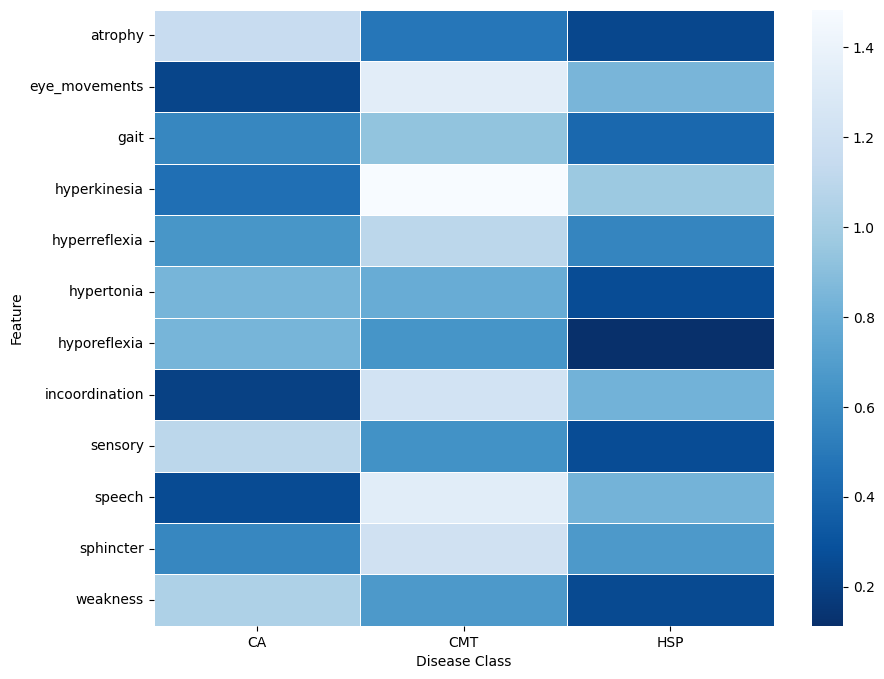

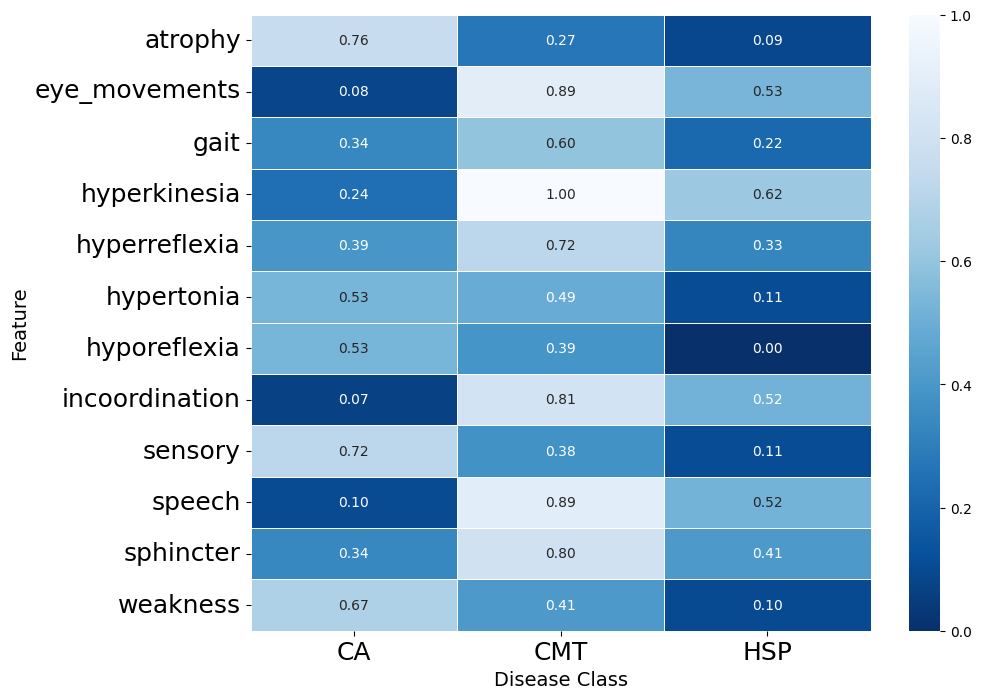

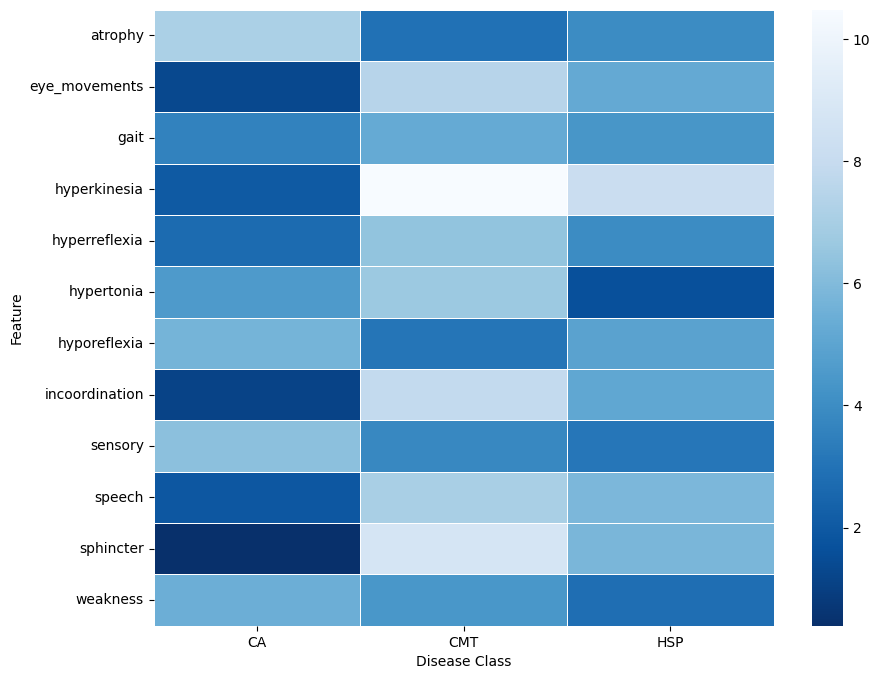

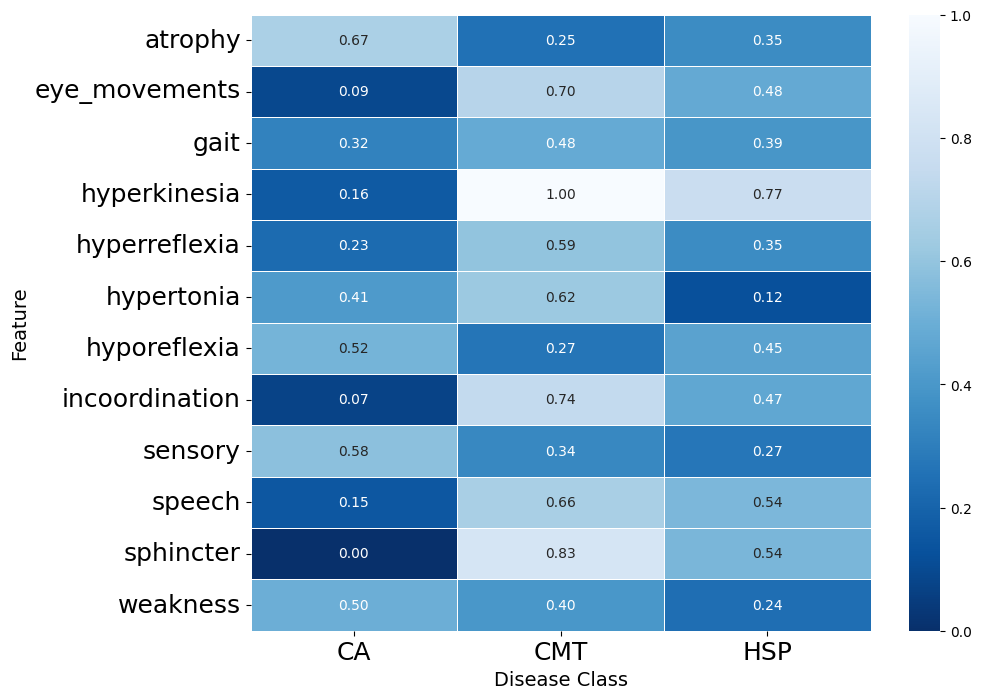

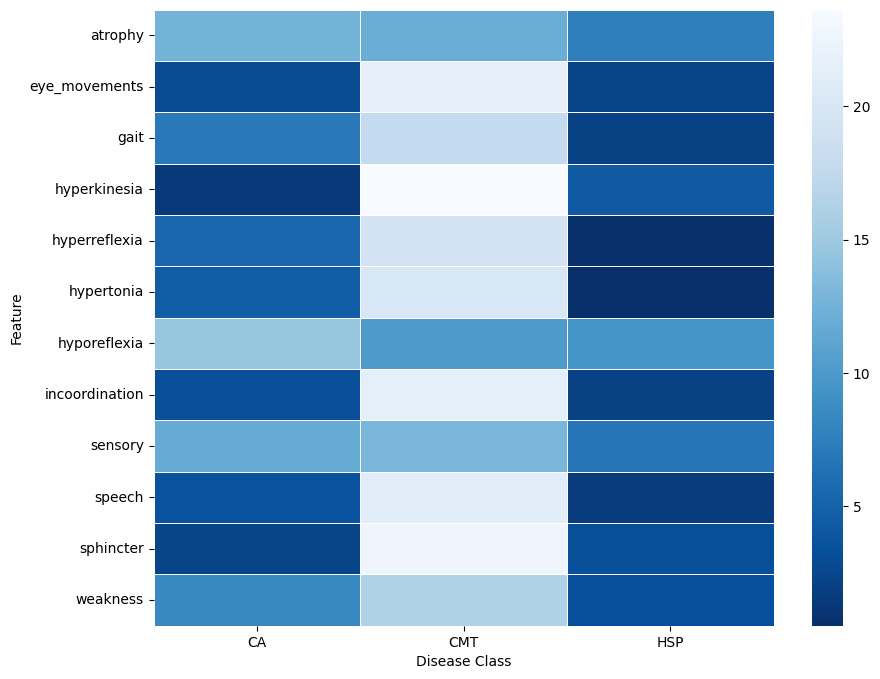

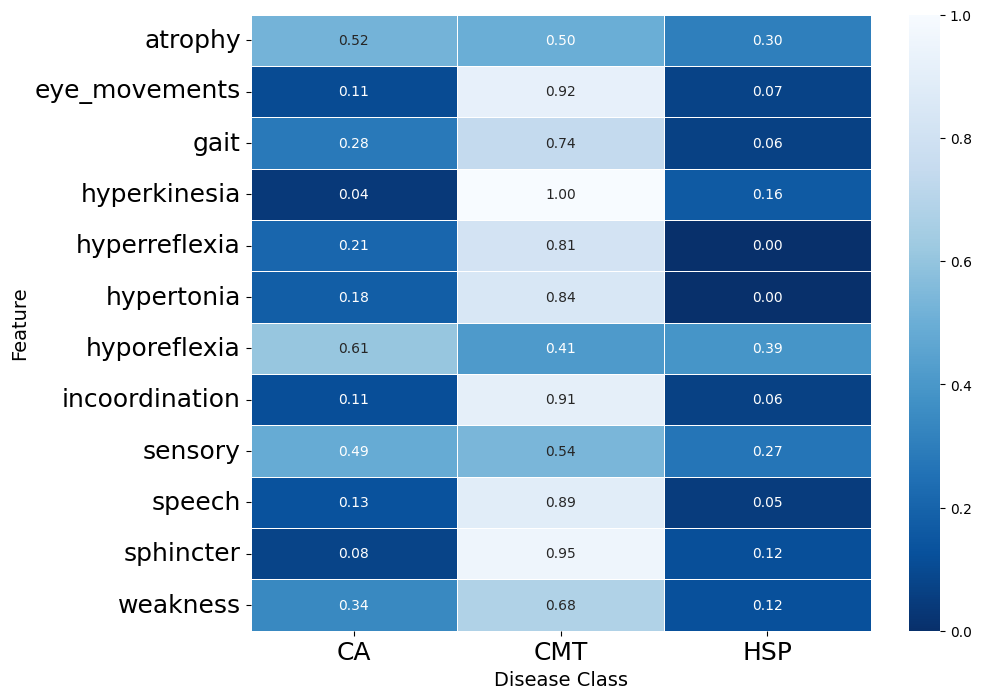

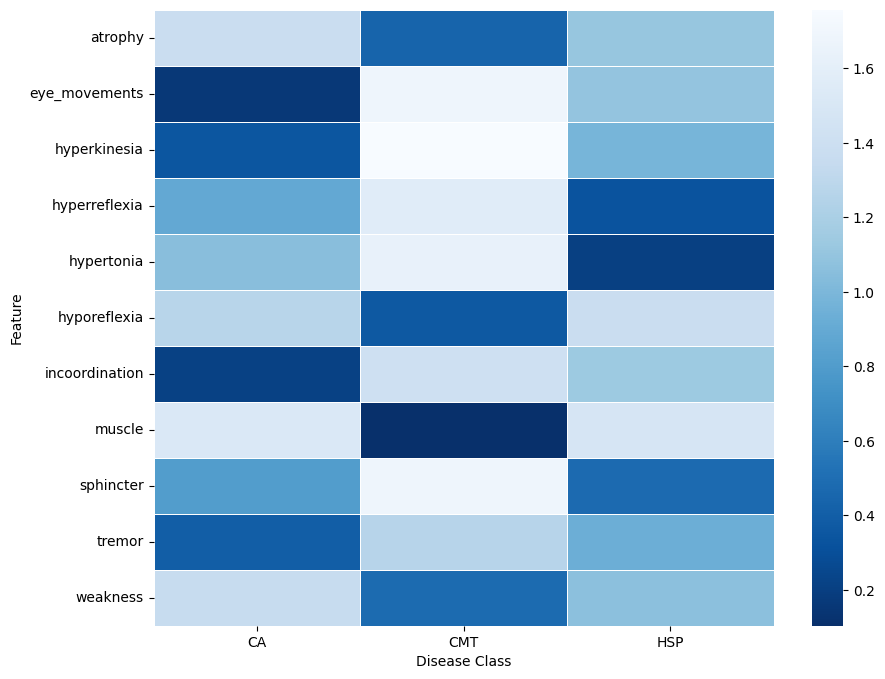

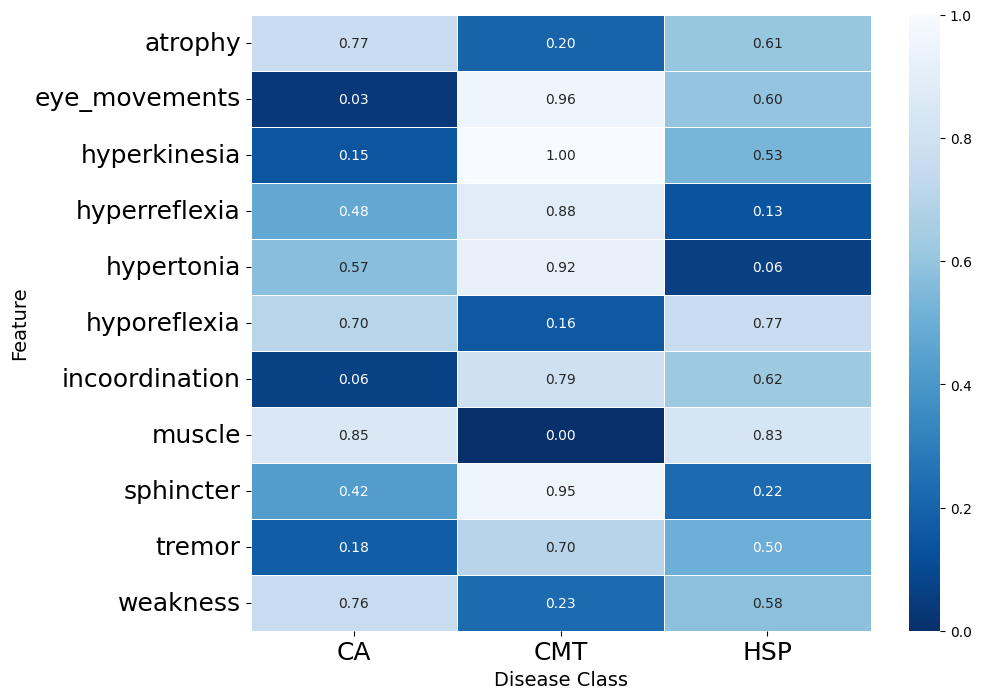

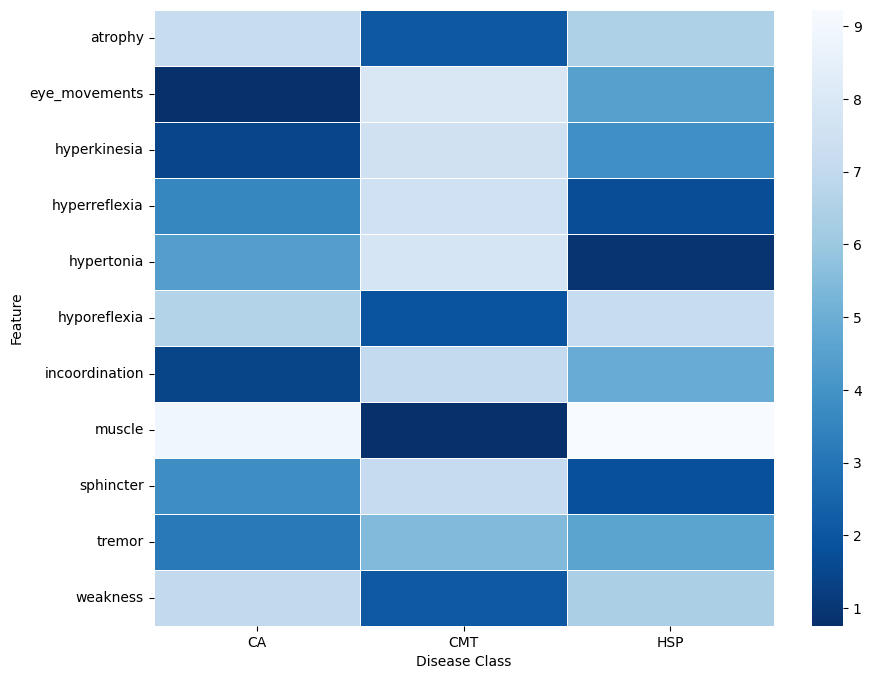

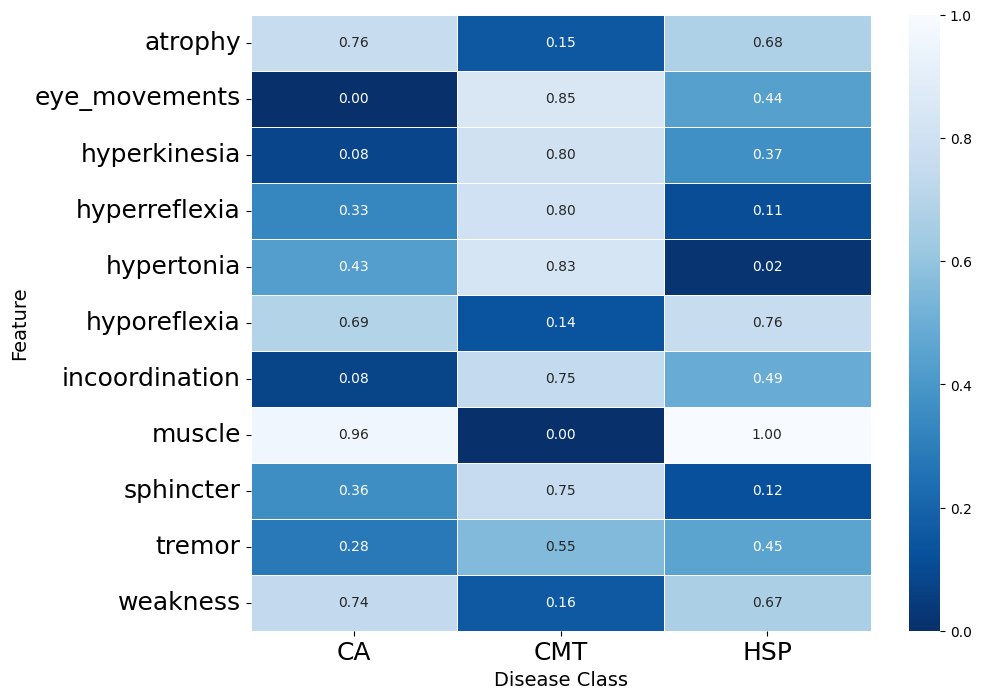

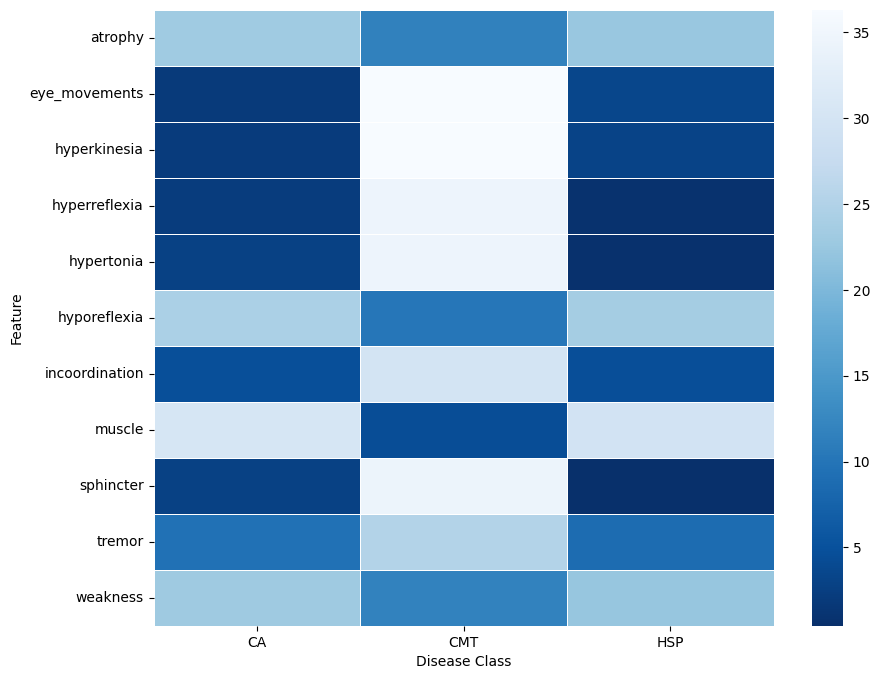

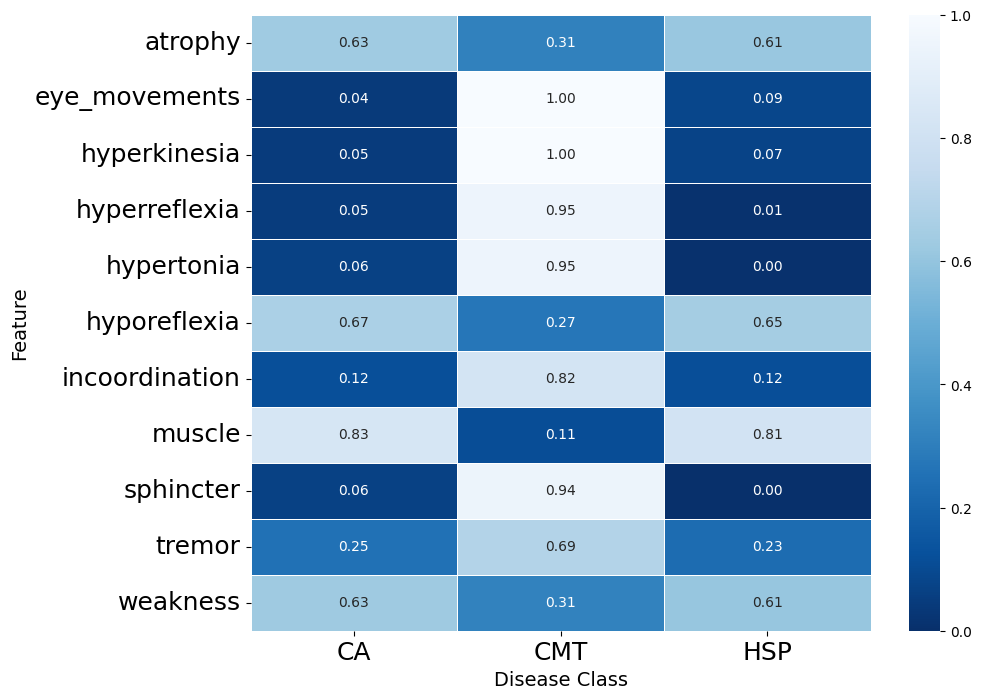

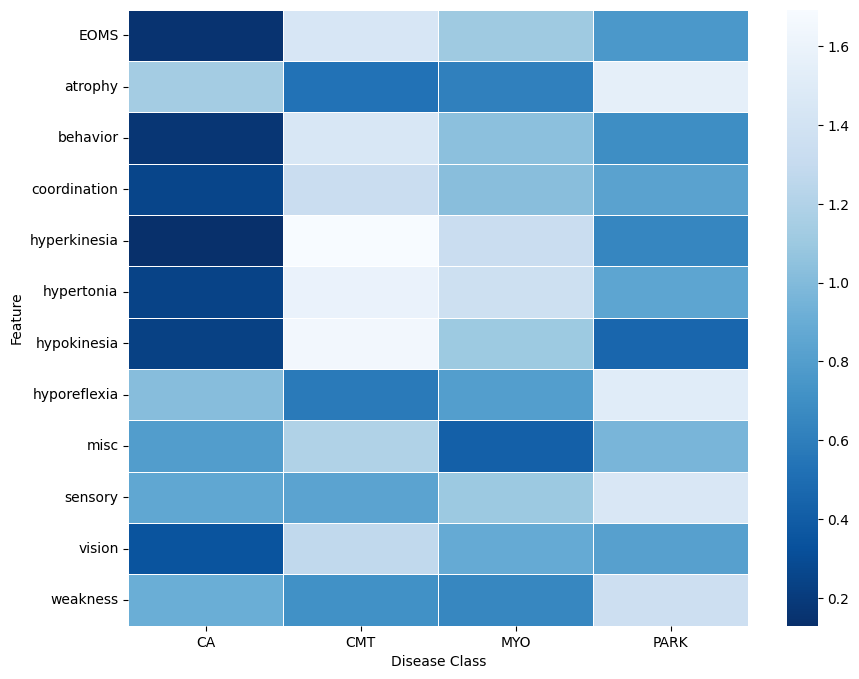

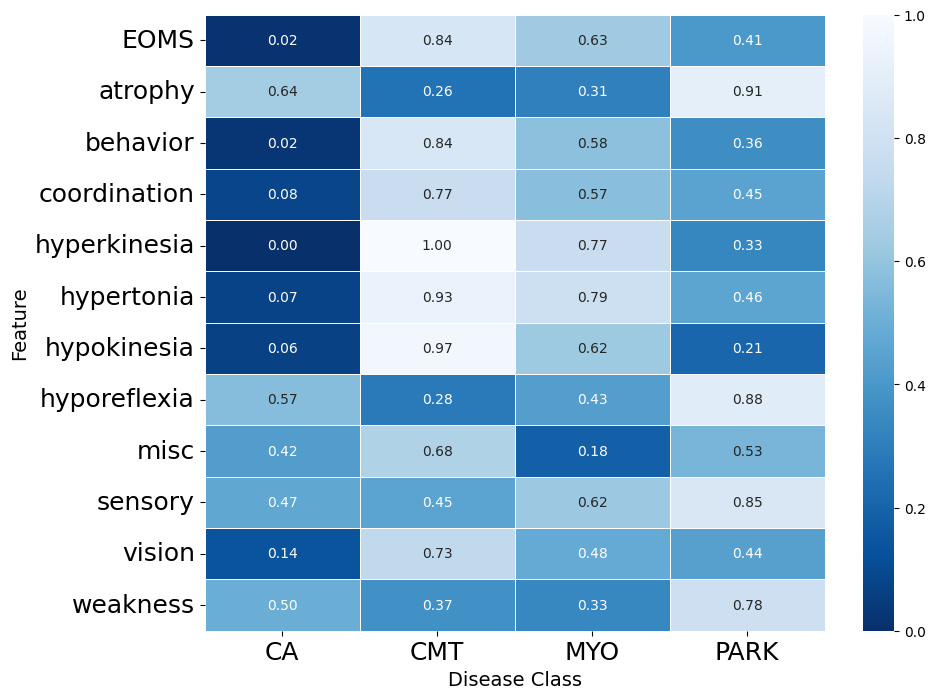

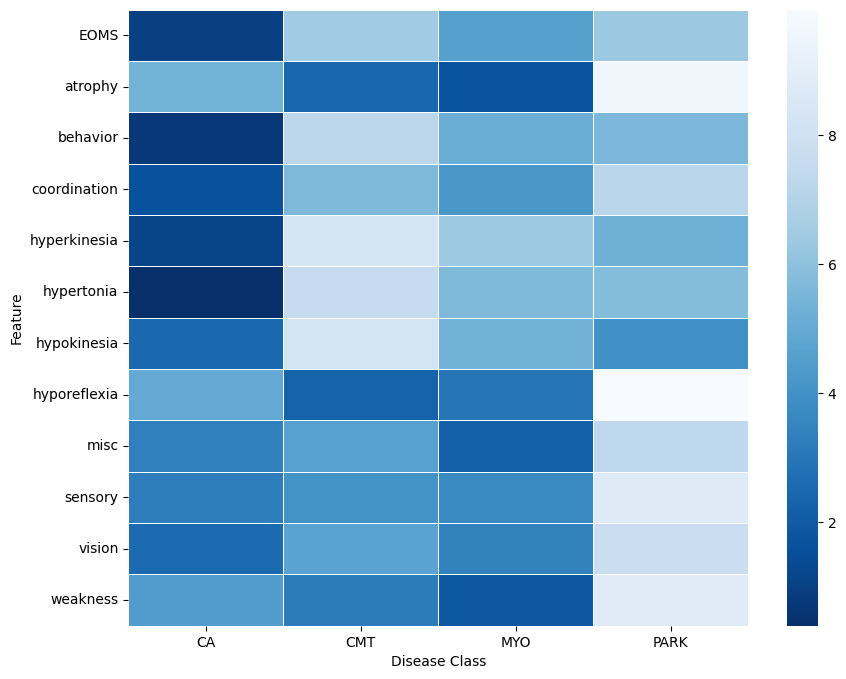

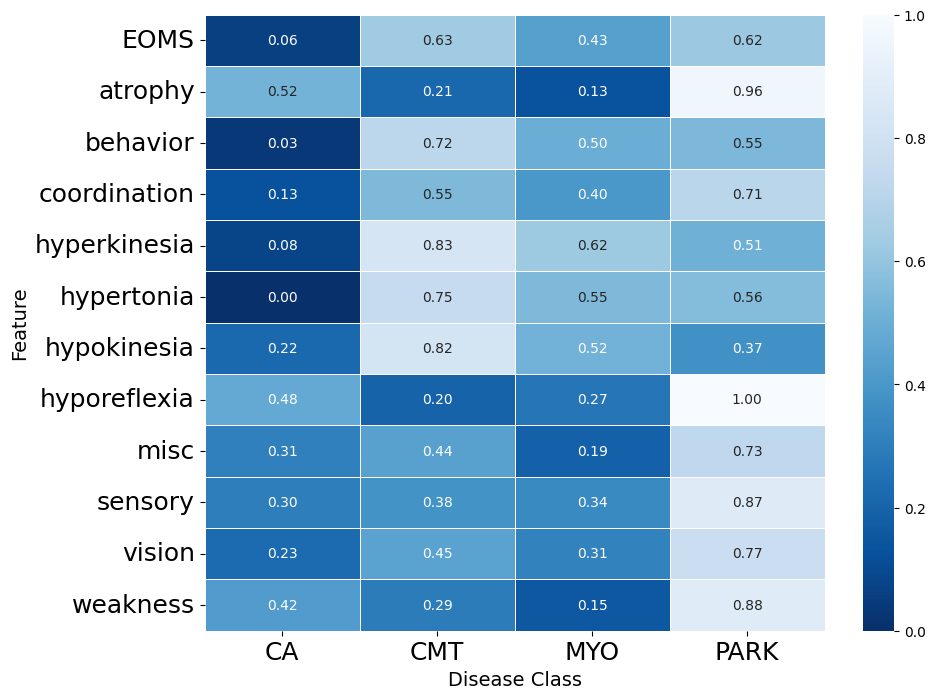

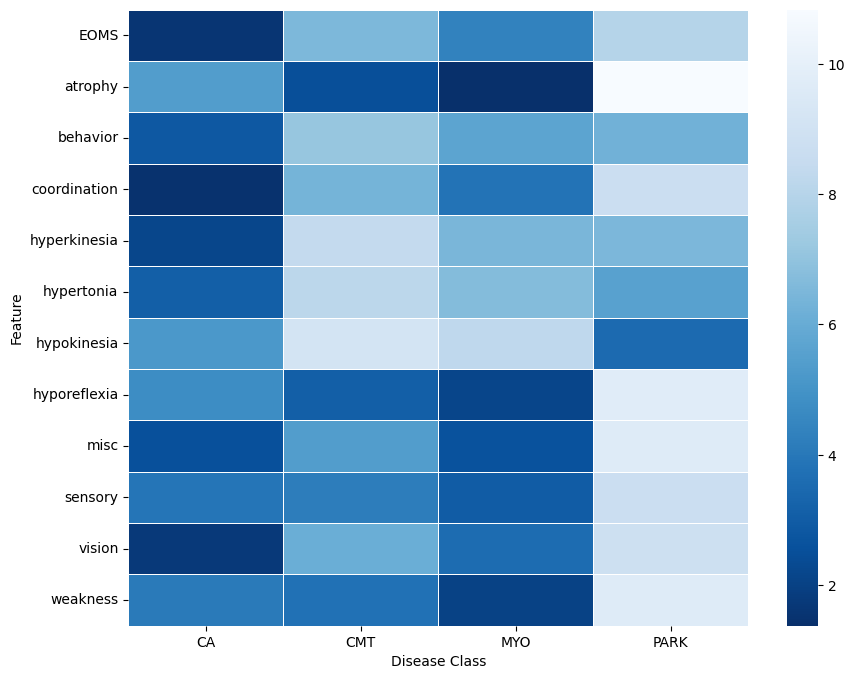

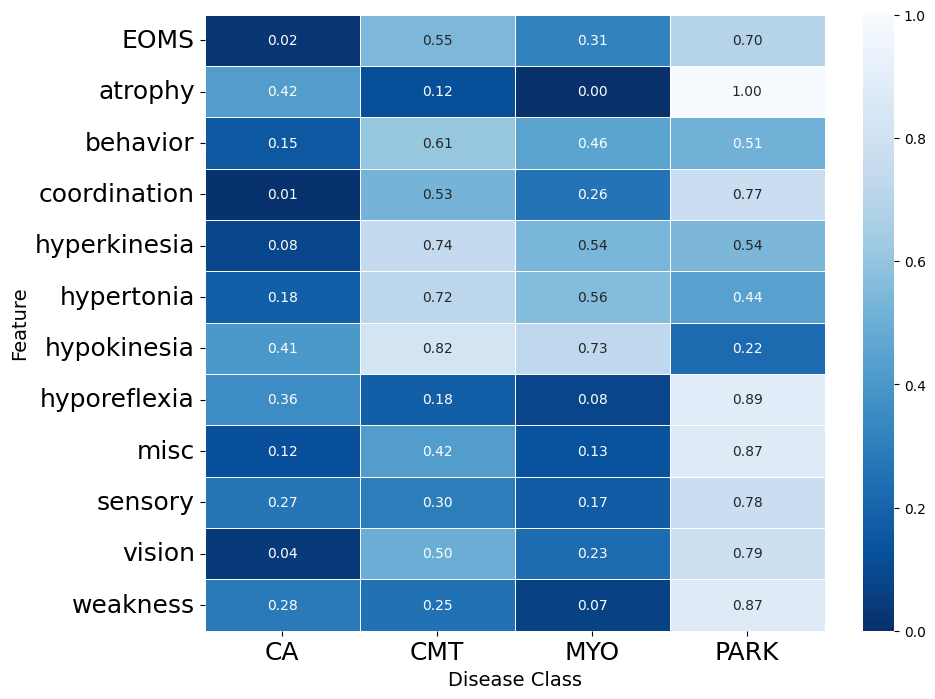

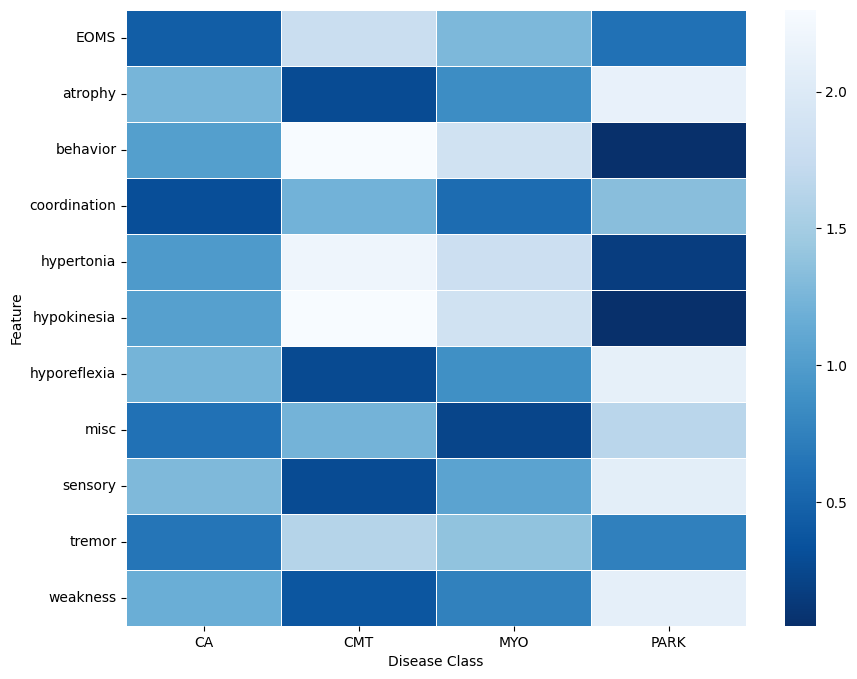

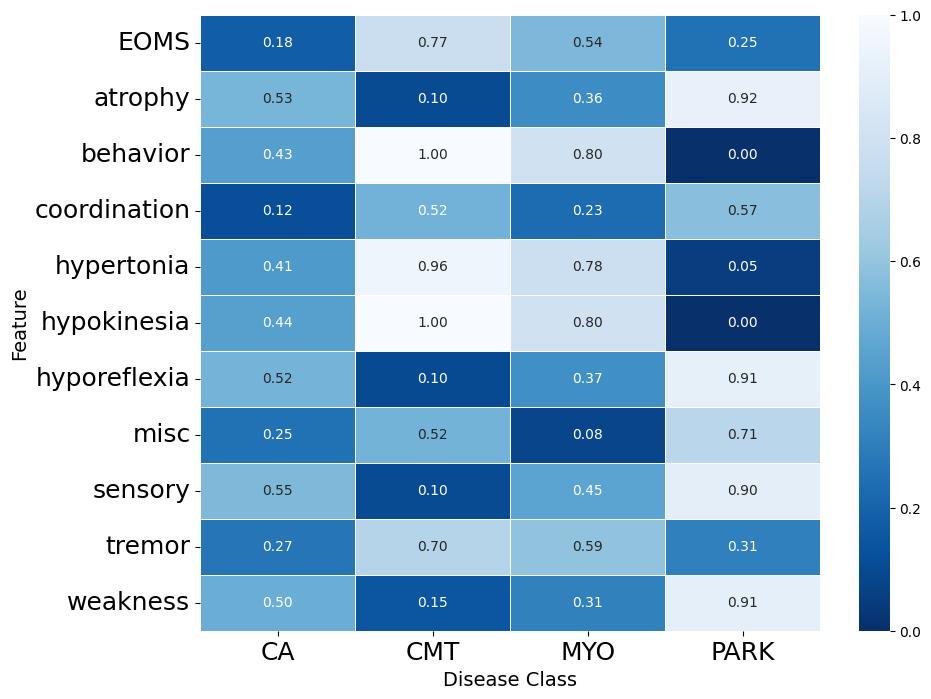

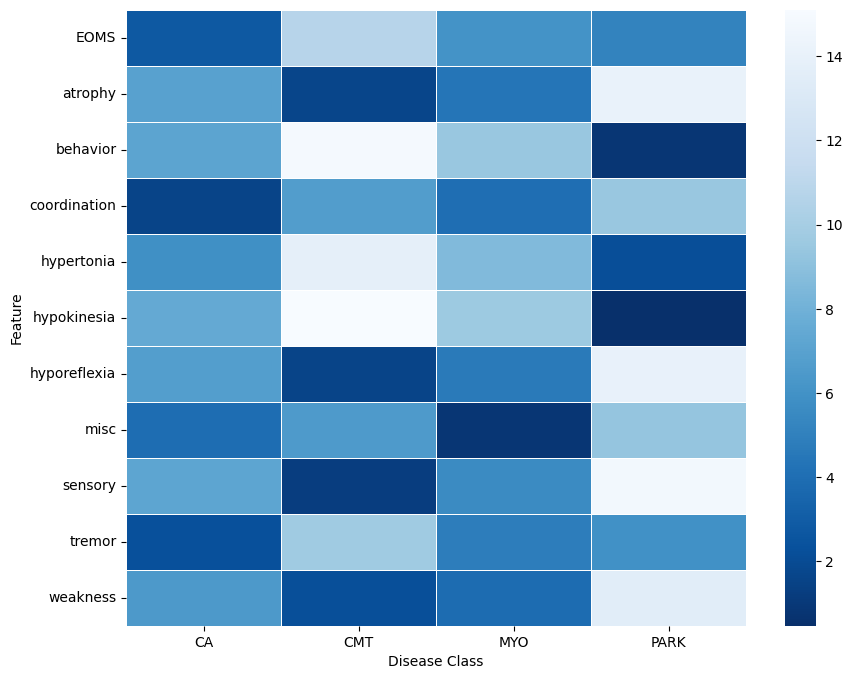

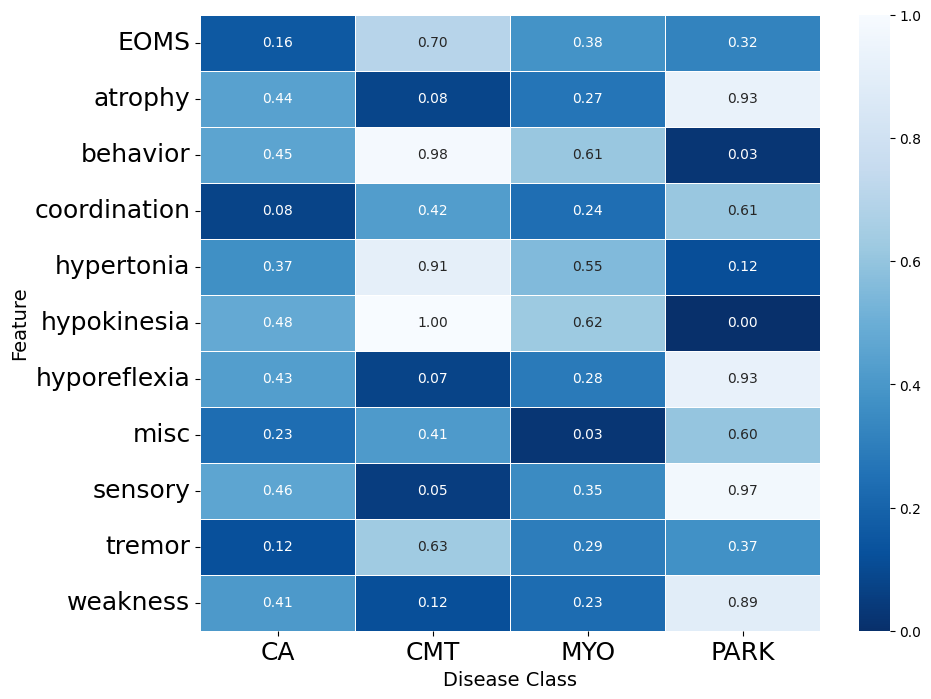

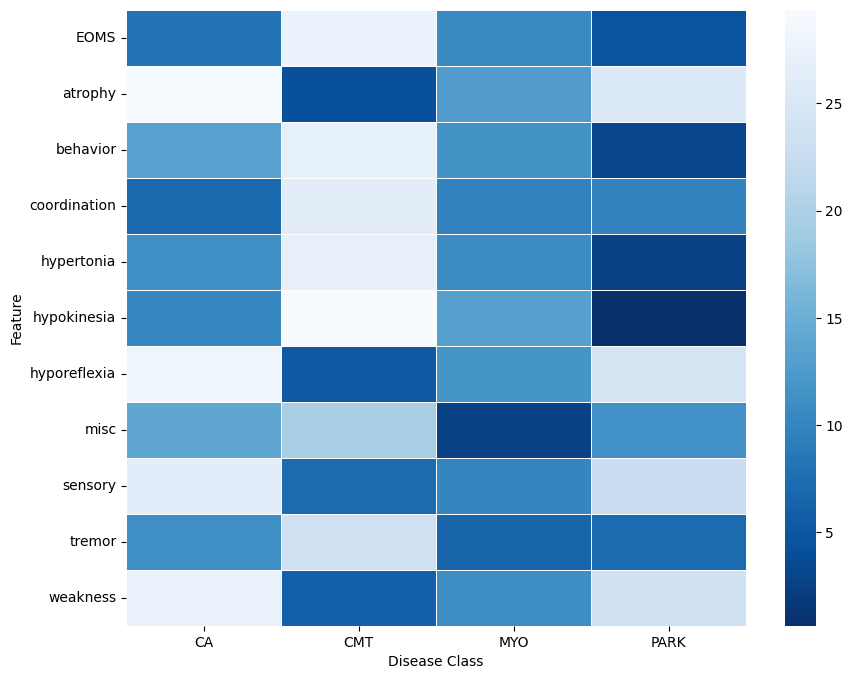

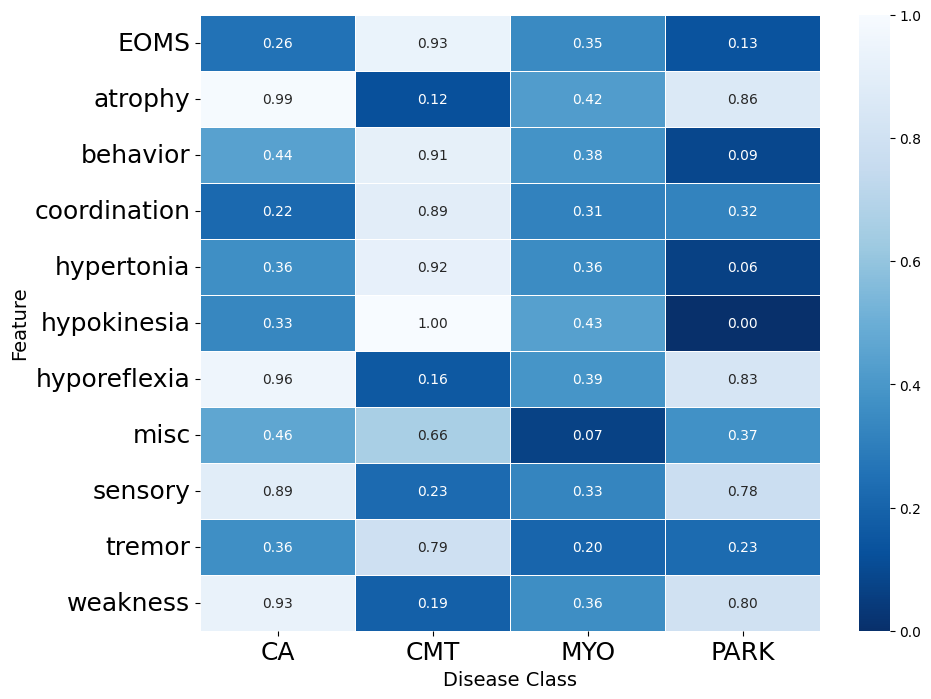

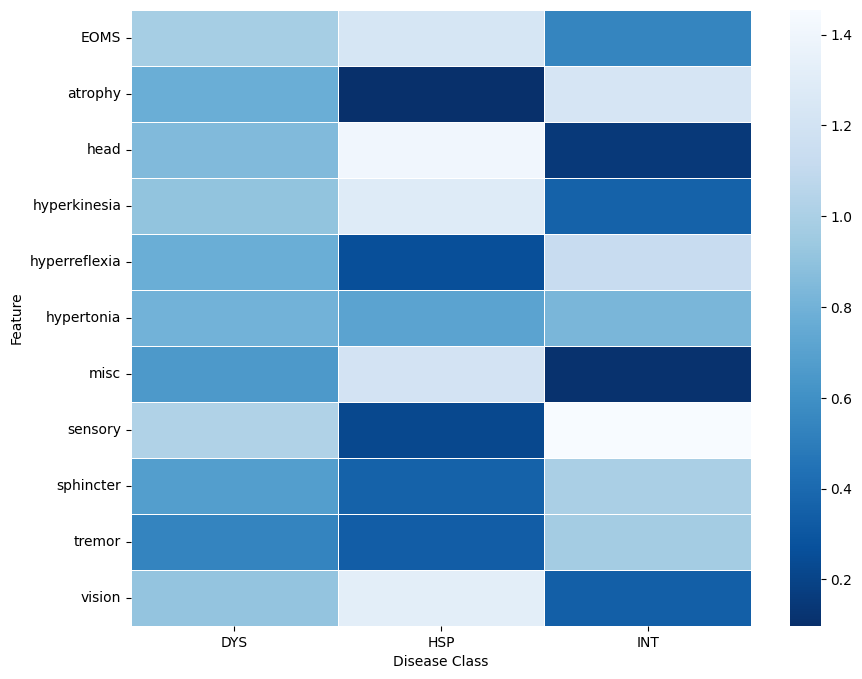

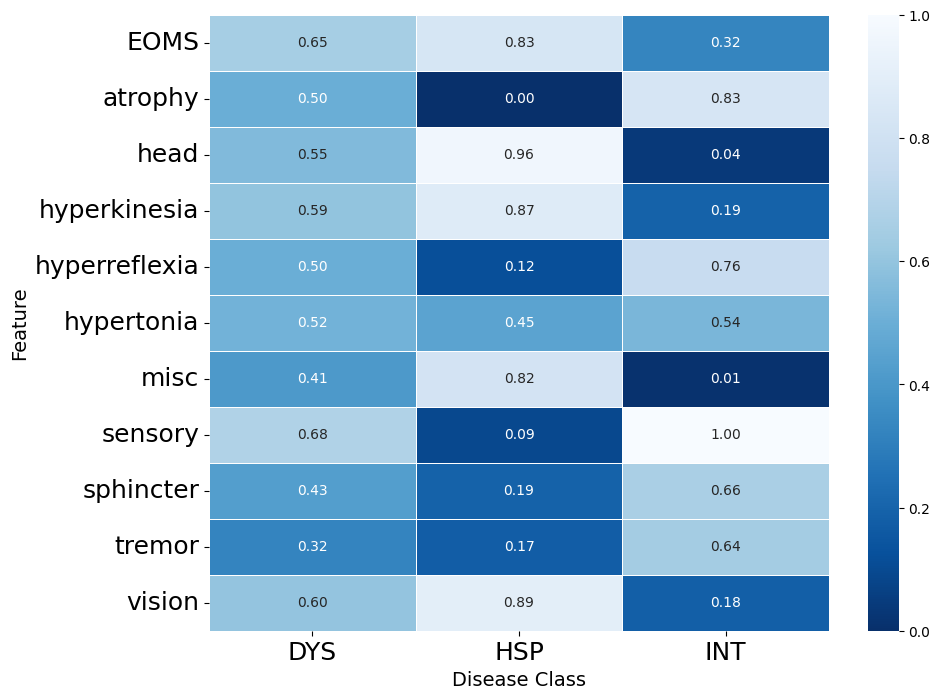

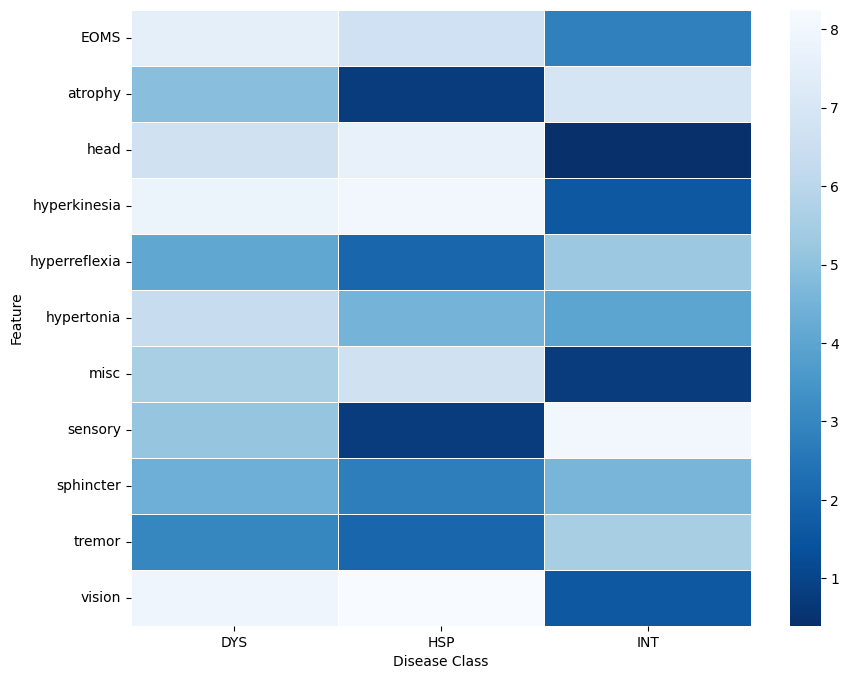

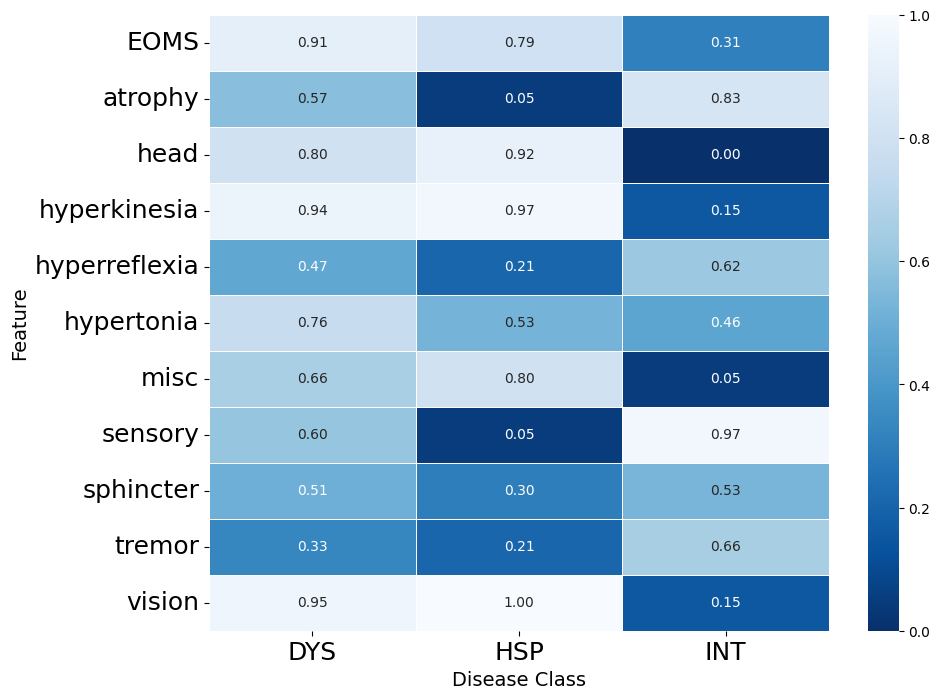

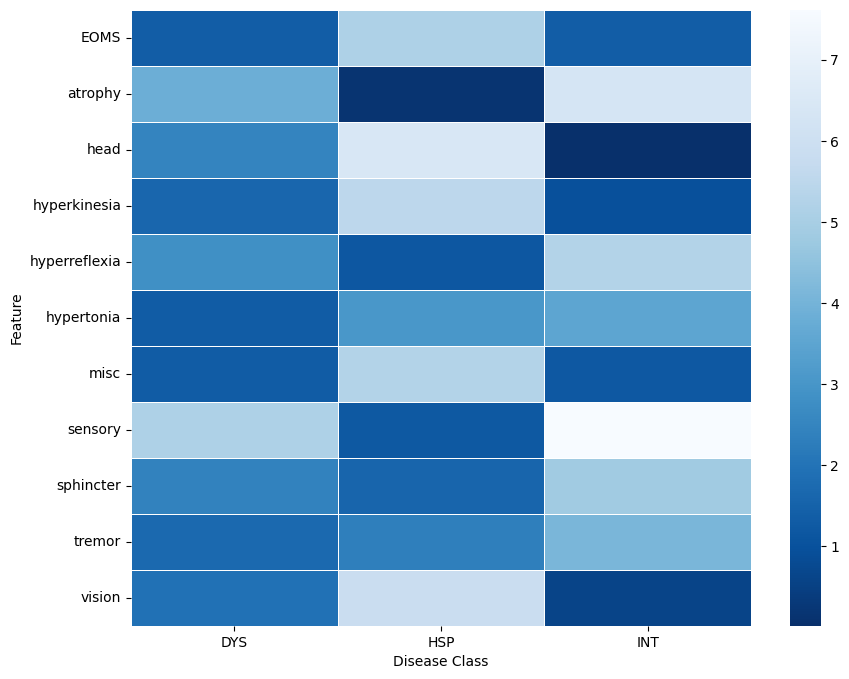

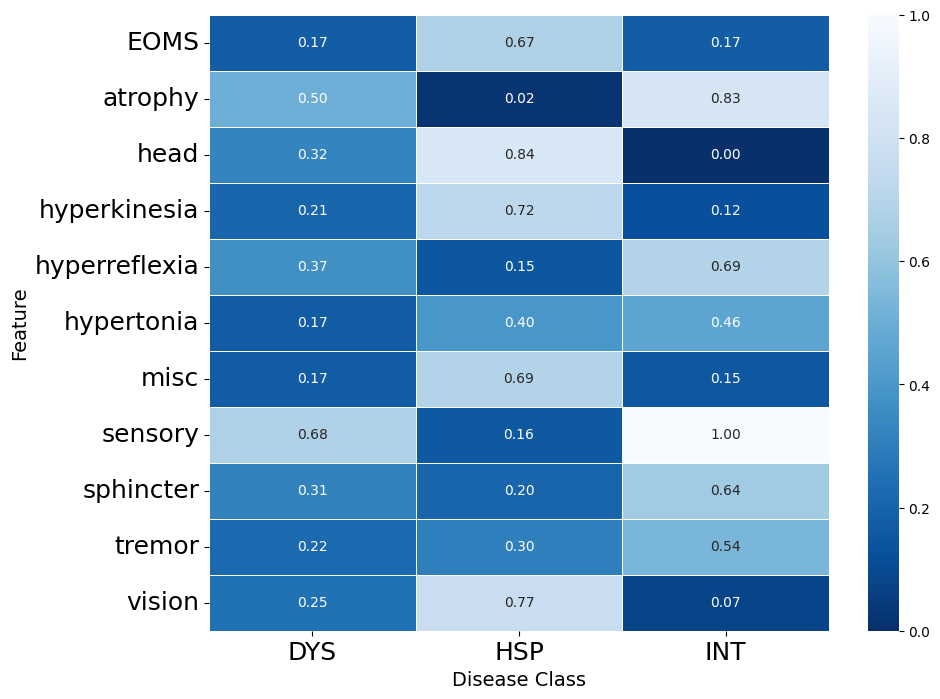

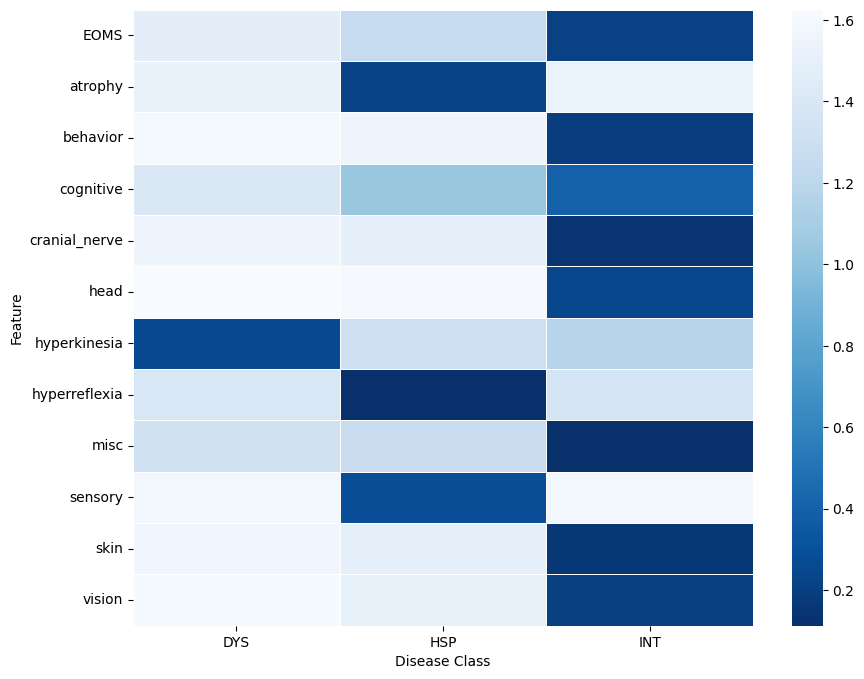

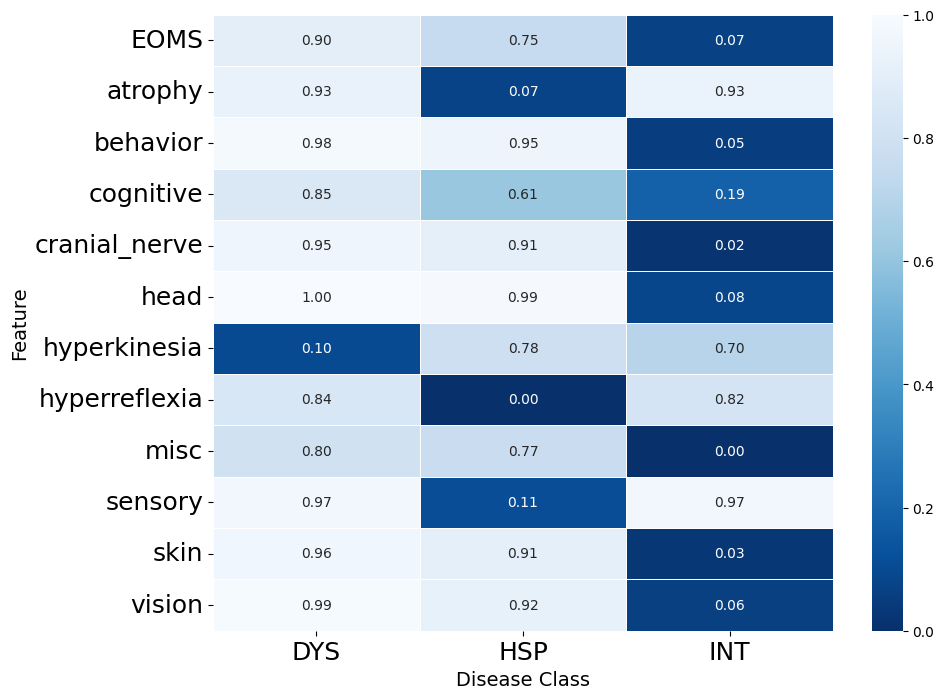

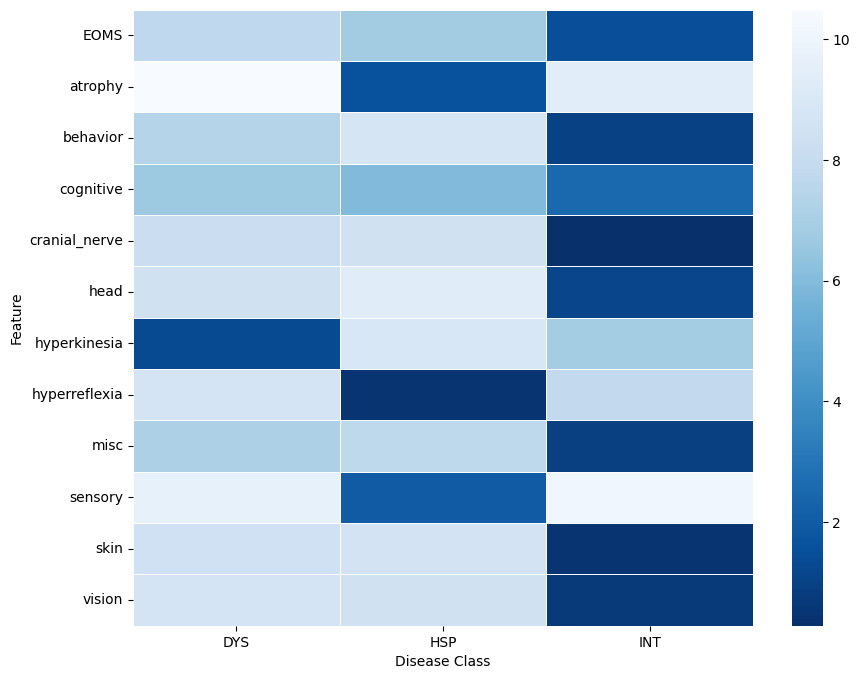

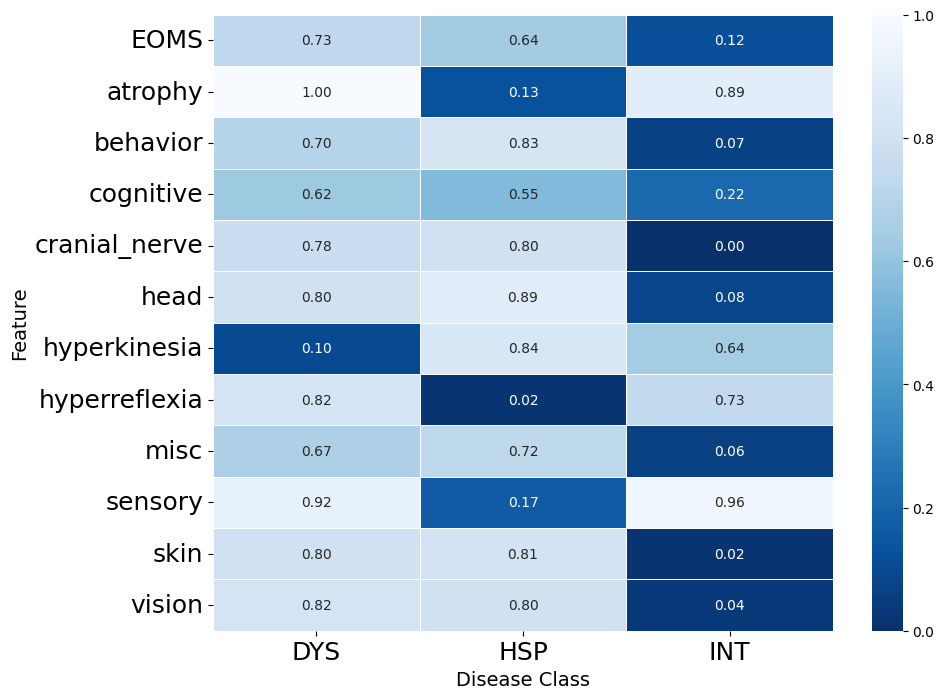

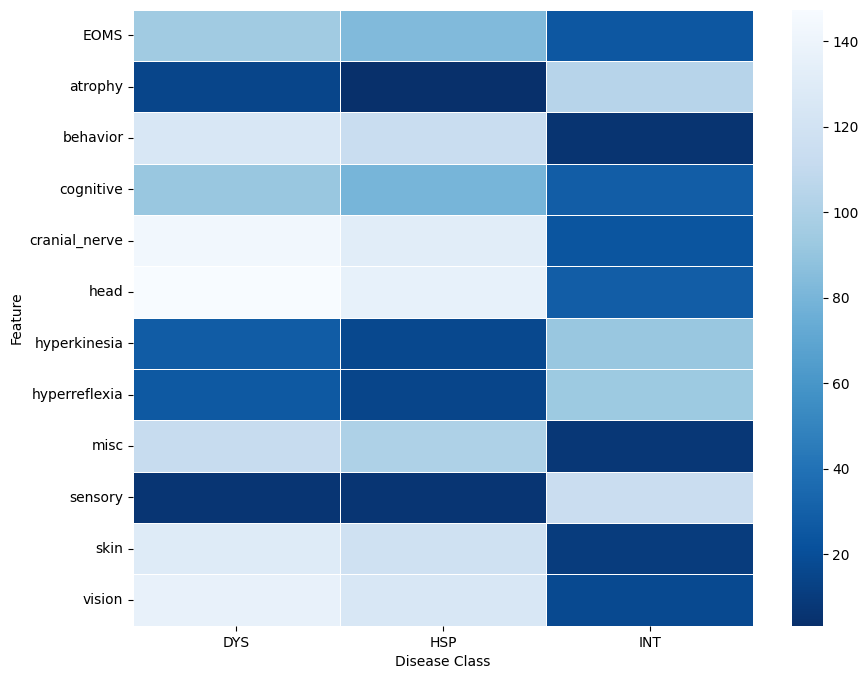

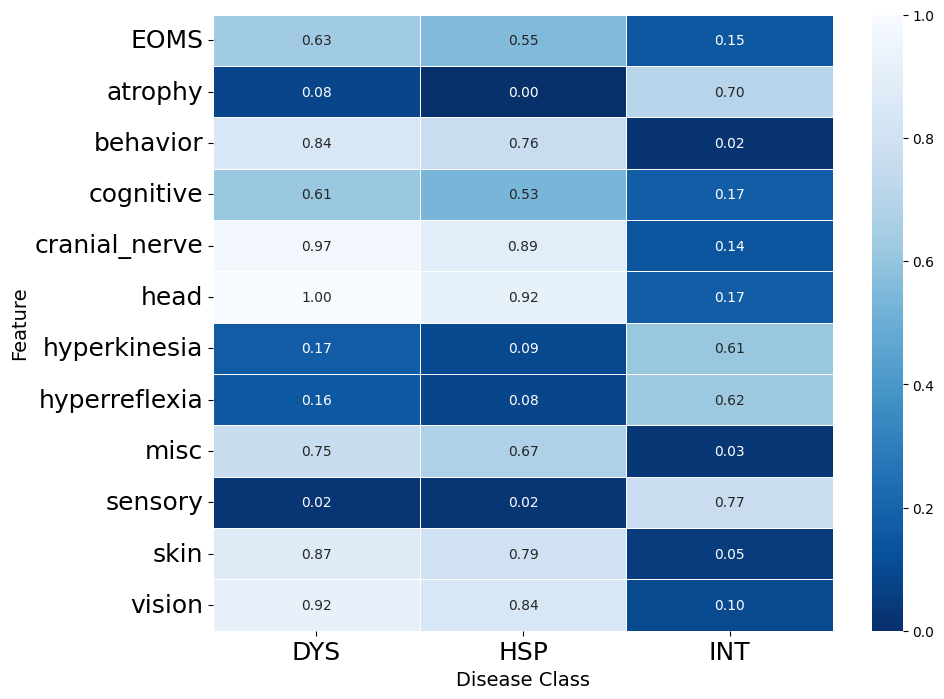

In [4]:
# DELETE THIS LATER! THIS IS FOR TESTING CODE - CHANGE WHEN GETTING BEST PARAMS!!!!
best_t_sne_params = [({'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/_neurogenetic.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 14, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/_neurogenetic_balanced.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 12, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes.csv'), ({'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 12, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes_balanced.csv')]
#[({'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 14, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes.csv'), ({'init': 'pca', 'perplexity': 60, 'method': 'exact', 'early_exaggeration': 10, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 10, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 12, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes_balanced.csv')]

#[({'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/_neurogenetic.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 14, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/_neurogenetic_balanced.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 12, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'init': 'pca', 'perplexity': 70, 'method': 'exact', 'early_exaggeration': 4, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes.csv'), ({'init': 'pca', 'perplexity': 50, 'method': 'exact', 'early_exaggeration': 12, 'n_iter': 1000, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes_balanced.csv')]
best_umap_params = [({'n_neighbors': 20, 'min_dist': 0.1, 'metric': 'euclidean', 'spread': 1.5}, '../datasets/_neurogenetic.csv'), ({'n_neighbors': 100, 'min_dist': 0.1, 'metric': 'manhattan', 'spread': 1.5}, '../datasets/_neurogenetic_balanced.csv'), ({'n_neighbors': 30, 'min_dist': 0.4, 'metric': 'euclidean', 'spread': 1.25}, '../datasets/neurogenetic_4_4classes.csv'), ({'n_neighbors': 100, 'min_dist': 0.2, 'metric': 'manhattan', 'spread': 1.25}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'n_neighbors': 40, 'min_dist': 0.2, 'metric': 'manhattan', 'spread': 0.75}, '../datasets/neurogenetic_4_3classes.csv'), ({'n_neighbors': 80, 'min_dist': 0.1, 'metric': 'euclidean', 'spread': 1.0}, '../datasets/neurogenetic_4_3classes_balanced.csv')]
#[({'n_neighbors': 30, 'min_dist': 0.4, 'metric': 'euclidean', 'spread': 1.25}, '../datasets/neurogenetic_4_4classes.csv'), ({'n_neighbors': 100, 'min_dist': 0.2, 'metric': 'manhattan', 'spread': 1.25}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'n_neighbors': 40, 'min_dist': 0.2, 'metric': 'manhattan', 'spread': 0.75}, '../datasets/neurogenetic_4_3classes.csv'), ({'n_neighbors': 80, 'min_dist': 0.1, 'metric': 'euclidean', 'spread': 1.0}, '../datasets/neurogenetic_4_3classes_balanced.csv')]
#[({'n_neighbors': 30, 'min_dist': 0.0, 'metric': 'euclidean'}, '../datasets/_neurogenetic.csv'), ({'n_neighbors': 20, 'min_dist': 0.2, 'metric': 'euclidean'}, '../datasets/_neurogenetic_balanced.csv'), ({'n_neighbors': 15, 'min_dist': 0.8, 'metric': 'manhattan'}, '../datasets/neurogenetic_4_4classes.csv'), ({'n_neighbors': 70, 'min_dist': 0.0, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_4classes_balanced.csv'), ({'n_neighbors': 50, 'min_dist': 0.0, 'metric': 'manhattan'}, '../datasets/neurogenetic_4_3classes.csv'), ({'n_neighbors': 80, 'min_dist': 0.1, 'metric': 'euclidean'}, '../datasets/neurogenetic_4_3classes_balanced.csv')]

def get_best_parameters(dataset_path, parameters_list):
  for params, path in parameters_list:
      if path == dataset_path:
          return params
  return None


for base_directory_path, dataset_path in datasets:
  print(f"Processing: {dataset_path}")
  # Make sure the output directories exist
  #tsne_directory_path, pca_directory_path, umap_directory_path = setup_directories(base_directory_path)
  tsne_directory_path = os.path.join(base_directory_path, "t_sne_plots")
  pca_directory_path = os.path.join(base_directory_path, "pca_plots")
  umap_directory_path = os.path.join(base_directory_path, 'umap_plots')
  
  for path in [tsne_directory_path, umap_directory_path, pca_directory_path]:
      os.makedirs(path, exist_ok=True)

  
  # Read in the data
  neurogenetic = pd.read_csv(dataset_path)

  labels = neurogenetic[['type', 'name']] if 'name' in neurogenetic.columns else neurogenetic[['type']]
  type_counts = labels['type'].value_counts()

  # FEATURES FOR ALL THE FEATURES IN A DATASET
  # features_to_consider = neurogenetic.columns[2:]
  # FEATURES FOR TOP 10-12 IN A DATASET
  dataset_name = os.path.basename(dataset_path).split('.')[0]  
  excel_df = pd.read_excel(excel_path, sheet_name=dataset_name[:31])
  top_features = excel_df[excel_df['Top_12'] == 'Yes']['Feature']
  features_to_consider = top_features.tolist()

  best_t_sne_param = get_best_parameters(dataset_path, best_t_sne_params)
  best_umap_param = get_best_parameters(dataset_path, best_umap_params)

  features = neurogenetic[features_to_consider].applymap(lambda x: 1 if x > 0 else 0)

  # Custom variable setup (same as before)
  # custom_colors = ['dodgerblue', 'olive', 'magenta', 'midnightblue', 'red', 'darkmagenta', 'orange']
  # Updated color assignments
  abbreviations_colors = {
      'INT': 'dodgerblue',
      'CA': 'olive',
      'HSP': 'magenta',
      'CMT': 'midnightblue',
      'DYS': 'red',
      'PARK': 'darkmagenta',
      'MYO': 'orange'
  }
  # Convert disease labels to abbreviations for consistent color mapping
  abbreviations = {
      'intellectual_disability': 'INT',
      'ataxia': 'CA',
      'spastic_paraplegia': 'HSP',
      'Charcot-Marie-Tooth': 'CMT',
      'dystonia': 'DYS',
      'Parkinson': 'PARK',
      'myopathy': 'MYO'
  }
  unique_labels = labels['type'].unique()
  print(unique_labels)
  labels.replace(abbreviations, inplace=True)
  #print(labels)
  # Generate label_to_color mapping using abbreviations
  label_to_color = {abbr: abbreviations_colors[abbr] for abbr in labels['type'].unique()}
  #label_to_color = {label: custom_colors[i % len(custom_colors)] for i, label in enumerate(unique_labels)}
  label_colors = [label_to_color[label] for label in labels['type']]

  # Perform dimensionality reduction
  # PCA
  pca = PCA(n_components=2, random_state=42)
  pca_result = pca.fit_transform(features)
  pca_plot_name_suffix = f"PCA_"
  pca_directory_path = os.path.join(base_directory_path, "pca_plots")
  generate_plots('PCA', pca_directory_path, pca_result, label_colors, label_to_color, type_counts, features_to_consider, neurogenetic, labels, pca_plot_name_suffix)

  # t-SNE
  if best_t_sne_param:
    tsne = TSNE(n_components=2, random_state=42, **best_t_sne_param)
    tsne_result = tsne.fit_transform(features)
    t_sne_plot_name_suffix = f"t_SNE_perp_{best_t_sne_param['perplexity']}_init_{best_t_sne_param['init']}_metric_{best_t_sne_param['metric']}"
    tsne_directory_path = os.path.join(base_directory_path, "t_sne_plots")
    generate_plots('t_SNE', tsne_directory_path, tsne_result, label_colors, label_to_color, type_counts, features_to_consider, neurogenetic, labels, t_sne_plot_name_suffix)

  # UMAP with the best parameters for the current dataset
  if best_umap_param:
    umap = UMAP(n_components=2, random_state=42, **best_umap_param)
    umap_result = umap.fit_transform(features)
    umap_plot_name_suffix = f"UMAP_neighbors_{best_umap_param['n_neighbors']}_dist_{best_umap_param['min_dist']}_metric_{best_umap_param['metric']}"#_spre_{best_umap_param['spread']}"
    umap_directory_path = os.path.join(base_directory_path, 'umap_plots')
    generate_plots('UMAP', umap_directory_path, umap_result, label_colors, label_to_color, type_counts, features_to_consider, neurogenetic, labels, umap_plot_name_suffix)

  print("Done with", dataset_path)

print("Done!")